# LSST SSP Daily Data Products Prototype Pipeline

Based on the DP0.3 optimized code, simplified for the Rubin pipelines

In [4]:
%load_ext autoreload
%autoreload 2

import go

In [5]:
import pandas as pd
import numpy as np
import astropy, astropy.coordinates
import matplotlib.pyplot as plt
from astropy.time import Time

pd.set_option("display.max_columns", None)

// ss_source_associated

// https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTCam/DRP/pipeline_drp_pipe_LSSTCam_DRP_step4b-measure-variability-tracts.pdf

// 

## Configuration

In [8]:
input_dir = "./inputs"
output_dir = "./outputs"

## A look at the inputs

Rubin data from the MPC, and the corresponding file from the butler.

In [4]:
dia = pd.read_parquet(f'{input_dir}/dia_sources.parquet', engine="pyarrow",  dtype_backend="pyarrow").reset_index(drop=True)

# DEBUG: while debugging, remove some indices and resort the array
dia = dia.sample(frac=0.9, random_state=42).reset_index(drop=True)

## Construct the association part of the SSSource table

Inputs: obs_sbn, current_identifications, numbered_identifications

In [172]:
det = pd.read_parquet(f'{input_dir}/obs_sbn.parquet', engine="pyarrow",  dtype_backend="pyarrow").reset_index()
det.columns

Index(['index', 'id', 'trksub', 'trkid', 'obsid', 'submission_id',
       'submission_block_id', 'obs80', 'status', 'ref', 'healpix', 'permid',
       'provid', 'artsat', 'mode', 'stn', 'trx', 'rcv', 'sys', 'ctr', 'pos1',
       'pos2', 'pos3', 'poscov11', 'poscov12', 'poscov13', 'poscov22',
       'poscov23', 'poscov33', 'prog', 'obstime', 'ra', 'dec', 'rastar',
       'decstar', 'obscenter', 'deltara', 'deltadec', 'dist', 'pa', 'rmsra',
       'rmsdec', 'rmsdist', 'rmspa', 'rmscorr', 'delay', 'rmsdelay', 'doppler',
       'rmsdoppler', 'astcat', 'mag', 'rmsmag', 'band', 'photcat', 'photap',
       'nucmag', 'logsnr', 'seeing', 'exp', 'rmsfit', 'com', 'frq', 'disc',
       'subfrm', 'subfmt', 'prectime', 'precra', 'precdec', 'unctime', 'notes',
       'remarks', 'deprecated', 'localuse', 'nstars', 'prev_desig', 'prev_ref',
       'rmstime', 'created_at', 'updated_at', 'trkmpc', 'orbit_id',
       'designation_asterisk', 'all_pub_ref', 'shapeocc', 'obssubid',
       'replacesobsid', 'g

In [5]:
det = pd.read_parquet(f'{input_dir}/obs_sbn.parquet', engine="pyarrow",  dtype_backend="pyarrow").reset_index()

# DEBUG: cut this down to a much smaller table
sampled_provids = det['provid'].drop_duplicates().sample(10, random_state=42)
det = det[det['provid'].isin(sampled_provids)].reset_index()
print(len(det))

# FIXME: this will have to check if the ID's are IAU-style (with string prefixes)
det["obssubid"] = det["obssubid"].astype(int)
det = det[["trksub", "obssubid", "provid", "permid", "submission_id", "ra", "dec", "obstime", "designation_asterisk"]].copy()

# verify types didn't get mangled somewhere along the way from the database to here
expect_dtypes = dict(
    trksub="string[pyarrow]",
    obssubid="int64",
    provid="string[pyarrow]",
    permid="string[pyarrow]",
    submission_id="string[pyarrow]",
    ra="double[pyarrow]",
    dec="double[pyarrow]",
    obstime="timestamp[us][pyarrow]",
    designation_asterisk="bool[pyarrow]",
)

for col in det.columns:
    assert det[col].dtype == expect_dtypes[col]

2011


Merge the `obs_sbn` record with the raw `DiaSource` butler catalog record. It's not a priori a mistake if some DiaSources don't exist (they may have been reported to the MPC from other processing runs), or if there are DiaSources that aren't in obs_sbn (DiaSource table can be a superset, holding static sources as well.)

In [6]:
# create the association side table
assoc = dia[["diaSourceId"]].reset_index().merge(det.add_prefix("mpc_"), left_on="diaSourceId", right_on="mpc_obssubid", how="inner")
assoc.rename(columns={'index': 'dia_index'}, inplace=True)

# verify all went well
assert np.all(dia["diaSourceId"].iloc[assoc["dia_index"]].to_numpy() == assoc["diaSourceId"].to_numpy())

# verify contents of the association table
go.assoc_validate(dia, assoc)

totalNumObs = len(assoc)

Separation diffeerence range (arcsec):  1.0404526860960233e-05 0.002702680146989677
Time diffeerence range (sec):           -0.501675 0.499837
All OK, 1,796 observations.


### Resolve to primary designations

In [7]:
numid = pd.read_parquet(f'{input_dir}/numbered_identifications.parquet', engine="pyarrow", columns=["permid", "unpacked_primary_provisional_designation"], dtype_backend="pyarrow").reset_index(drop=True)
curid = pd.read_parquet(f'{input_dir}/current_identifications.parquet', engine="pyarrow",  dtype_backend="pyarrow", columns=["unpacked_primary_provisional_designation", "unpacked_secondary_provisional_designation", "packed_primary_provisional_designation"]).reset_index(drop=True)

In [8]:
# First step: some numbered objects in `obs_sbn` don't have their provID set. Restore it.
df = assoc[["mpc_provid", "mpc_permid"]].merge(numid, left_on="mpc_permid", right_on="permid", how="left")
assert len(df) == len(assoc)

assoc["mpc_provid"] = assoc["mpc_provid"].where(assoc["mpc_provid"].notna(), df["unpacked_primary_provisional_designation"])

assert not assoc["mpc_provid"].isna().any()
assert len(assoc) == totalNumObs

# Second step: update provisional designations with the primary ones.

df = assoc[["mpc_provid"]].merge(curid, left_on="mpc_provid", right_on="unpacked_secondary_provisional_designation", how="inner")
assoc["mpc_provid"] = df["unpacked_primary_provisional_designation"]
assoc["mpc_packed"] = df["packed_primary_provisional_designation"]

assert len(assoc) == totalNumObs

# sort the association table by object
assoc.sort_values(["mpc_provid"], inplace=True)

## Create the SSSource table


In [9]:
ssSourceDtype = np.dtype([
    ('diaSourceId', 'u8'),
    ('eclipticBeta', 'f8'),
    ('eclipticLambda', 'f8'),
    ('galacticB', 'f8'),
    ('galacticL', 'f8'),
    ('heliocentricDist', 'f4'),
    ('heliocentricVX', 'f4'),
    ('heliocentricVY', 'f4'),
    ('heliocentricVZ', 'f4'),
    ('heliocentricX', 'f4'),
    ('heliocentricY', 'f4'),
    ('heliocentricZ', 'f4'),
    ('phaseAngle', 'f4'),
    ('ephOffsetDec', 'f4'),
    ('ephOffsetRa', 'f4'),
    ('ssObjectId', 'u8'),
    ('topocentricDist', 'f4'),
    ('topocentricVX', 'f4'),
    ('topocentricVY', 'f4'),
    ('topocentricVZ', 'f4'),
    ('topocentricX', 'f4'),
    ('topocentricY', 'f4'),
    ('topocentricZ', 'f4'),
    ('unpacked_primary_provisional_designation', 'S12'),
    ('ephVmag', 'f4'),
    ('ephRa', 'f8'),
    ('ephDec', 'f8'),
    ('ephRate', 'f4'),
    ('ephRateRa', 'f4'),
    ('ephRateDec', 'f4'),
    ('ephOffset', 'f4'),
    ('topocentricV', 'f4'),
    ('heliocentricV', 'f4'),
    ('ephOffsetAlongTrack', 'f4'),
    ('ephOffsetCrossTrack', 'f4'),
    ('elongation', 'f4'),
])

ssSourceDtype.itemsize

184

Create the output array for SSSource:

In [10]:
sss = np.zeros(totalNumObs, dtype=ssSourceDtype)
sss.dtype.itemsize, len(sss), f"{sss.nbytes:,}"

(184, 1796, '330,464')

In [11]:
ssObjectIds = go.packed_ascii_to_uint64_le(assoc["mpc_packed"])

for n in np.unique(ssObjectIds)[:5]:
    b = int(n).to_bytes(8, "little")     # or "big"
    chars = ''.join(chr(x) for x in b)
    print(b)       # raw bytes

b' K05ST5F'
b' K25F11H'
b' K25M64J'
b' K25M24M'
b' K21PK2N'


In [12]:
#
# construct SSSource -- start with easily vectorizable columns
#
sss["diaSourceId"] = assoc["diaSourceId"].values
sss["ssObjectId"] = go.packed_ascii_to_uint64_le(assoc["mpc_packed"])
sss["unpacked_primary_provisional_designation"] = assoc["mpc_provid"]

df = dia[["ra", "dec", "midpointMjdTai"]].iloc[assoc["dia_index"]]
ra, dec, t = df["ra"].to_numpy(), df["dec"].to_numpy(), Time(df["midpointMjdTai"].to_numpy(), format="mjd", scale="tai")

sss["elongation"] = go.solar_elongation_ndarray(ra, dec, t)

# FIXME: verify these coordinate transforms replicate IAU76 at JPL
from astropy.coordinates import SkyCoord, HeliocentricEclipticIAU76
import astropy.units as u
p = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=1*u.au, frame='hcrs')
ecl = p.transform_to(HeliocentricEclipticIAU76)
p = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=1*u.au, frame='icrs')
gal = p.transform_to('galactic')

sss["eclipticLambda"] = ecl.lon
sss["eclipticBeta"] = ecl.lat
sss["galacticL"] = gal.l
sss["galacticB"] = gal.b


In [13]:
mpcorb = pd.read_parquet(f'{input_dir}/mpc_orbits.parquet', engine="pyarrow",  dtype_backend="pyarrow", 
                         columns=["unpacked_primary_provisional_designation", "packed_primary_provisional_designation", "a", "q", "e", "i", "node", "argperi", "peri_time",
                                  "mean_anomaly", "epoch_mjd", "h", "g"]
        ).reset_index(drop=True)

In [14]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

kms = u.km/u.s

def _aux_compute_ephemerides(provID, ephTimes):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    import jorbit
    from jorbit.utils.states import KeplerianState
    from jorbit.data.constants import SPEED_OF_LIGHT
    from jorbit import Particle

    # Ephemerides
    (packed, a, e, i, node, argperi, M, epoch, H, G) = mpcorb.query("unpacked_primary_provisional_designation == @provID", engine="python")["packed_primary_provisional_designation a e i node argperi mean_anomaly epoch_mjd h g".split()].iloc[0]

    # FIXME: hack until jorbit is fixed (https://github.com/ben-cassese/jorbit/issues/26)
    p = Particle.from_horizons(name=packed, time=Time(epoch, format="mjd", scale="tdb"))

    eph, xx, vv, obs = p.ephemeris(times=ephTimes, observer="rubin")

    xx, vv, obs = np.array(xx).T, np.array(vv).T, np.array(obs).T
    vv = (vv * u.au/u.day).to(kms).value # convert from AU/day to km/s

    # rate of motion
    dt = 1./(3600.+24.) * u.s
    ephTimes2 = ephTimes + dt
    eph2, _, _, _ = p.ephemeris(times=ephTimes2, observer="rubin")
    dlon, dlat = eph.spherical_offsets_to(eph2)  # small offsets on tangent plane
    mu_lon = (dlon / dt).to(u.deg/u.day)     # ≈ d(RA*cosDec)/dt
    mu_lat = (dlat / dt).to(u.deg/u.day)     # ≈ d(Dec)/dt
    mu = (eph.separation(eph2) / dt).to(u.deg/u.day) # total rate of motion


    return eph, (H, G), xx, vv, obs, mu_lon, mu_lat, mu

def phase_angle_deg(r_obj_sun, r_obs_sun):
    """
    Compute phase angle (Sun–Object–Observer) in degrees.

    Parameters
    ----------
    r_obj_sun : array, shape (3,) or (3, N)
        Object position vector wrt Sun (Sun → object).
    r_obs_sun : array, shape (3,) or (3, N)
        Observer position vector wrt Sun (Sun → observer).

    Returns
    -------
    float or ndarray
        Phase angle(s) in degrees, in [0, 180].
    """
    r_obj_sun = np.asarray(r_obj_sun)
    r_obs_sun = np.asarray(r_obs_sun)

    # Vectors at the object
    v_sun = -r_obj_sun                    # object → Sun
    v_obs = r_obs_sun - r_obj_sun         # object → observer

    # Dot products and norms along axis 0
    dot = np.sum(v_sun * v_obs, axis=0)
    norm_sun = np.linalg.norm(v_sun, axis=0)
    norm_obs = np.linalg.norm(v_obs, axis=0)

    cosang = dot / (norm_sun * norm_obs)
    cosang = np.clip(cosang, -1.0, 1.0)

    return np.degrees(np.arccos(cosang))

def hg_V_mag(H, G, r, delta, phase_deg):
    """
    Compute apparent V magnitude from the IAU H–G system.
    
    Parameters
    ----------
    H : float or ndarray
        Absolute magnitude (V-band).
    G : float or ndarray
        Slope parameter.
    r : float or ndarray
        Heliocentric distance in AU.
    delta : float or ndarray
        Observer distance (Δ) in AU.
    phase_deg : float or ndarray
        Phase angle in degrees.
    """
    a = np.radians(phase_deg) / 2.0

    # Phase functions
    phi1 = np.exp(-3.33 * np.tan(a)**0.63)
    phi2 = np.exp(-1.87 * np.tan(a)**1.22)

    phi = (1 - G) * phi1 + G * phi2

    return H + 5*np.log10(r * delta) - 2.5*np.log10(phi)

def compute_sssource_entry(sss, assoc):
    from astropy.coordinates import get_body_barycentric_posvel, solar_system_ephemeris
    import astropy.units as u

    # cut it out of the global dia array
    # FIXME: this is an ugly hack
    dia = globals()['dia']
    dia = dia.iloc[assoc["dia_index"]]

    # just verify we didn't screw up something
    assert np.all(dia["ssObjectId"] == dia["ssObjectId"].iloc[0])
    assert np.all(sss["ssObjectId"] == sss["ssObjectId"][0])
    assert len(dia) == len(sss)
    nobs = len(sss)

    provID = sss["unpacked_primary_provisional_designation"][0]
    ephTimes = Time(dia["midpointMjdTai"].values, format="mjd", scale="tai")
    eph, (H, G), xx, vv, obs, mu_lon, mu_lat, mu = _aux_compute_ephemerides(provID, ephTimes)

    sss["ephRateRa"] = mu_lon.value
    sss["ephRateDec"] = mu_lat.value
    sss["ephRate"] = mu.value

    # location/velocity of the Sun
    with solar_system_ephemeris.set("de440"):
        pos, vel = get_body_barycentric_posvel("sun", ephTimes)
    hx, hy, hz = pos.x.to(u.au).value, pos.z.to(u.au).value, pos.z.to(u.au).value
    hvx, hvy, hvz = vel.x.to(kms).value, vel.y.to(kms).value, vel.z.to(kms).value

    # location/velocity of the observer
    robs, vobs = go.observatory_barycentric_posvel("X05", ephTimes)
    robs = robs.to(u.au).value
    vobs = vobs.to(u.km/u.s).value
    #r_obs_sun = np.sqrt((robs * robs).sum(axis=0))

    sss["ephRa"] = eph.ra.deg
    sss["ephDec"] = eph.dec.deg
    obsv = SkyCoord(ra=dia["ra"], dec=dia["dec"], unit="deg", frame="icrs")

    sss["ephOffsetDec"] = (dia["dec"].to_numpy() - sss["ephDec"]) * 3600
    sss["ephOffsetRa"]  = (dia["ra"].to_numpy() - sss["ephRa"]) * np.cos(np.deg2rad(sss["ephDec"])) * 3600
    sss["ephOffset"]    = eph.separation(obsv).arcsec

    sss["heliocentricX"] = xx[0] - hx
    sss["heliocentricY"] = xx[1] - hy
    sss["heliocentricZ"] = xx[2] - hz
    sss["heliocentricDist"] = np.sqrt(sss["heliocentricX"]**2 + sss["heliocentricY"]**2 + sss["heliocentricZ"]**2)

    sss["topocentricX"] = xx[0] - obs[0]
    sss["topocentricY"] = xx[1] - obs[1]
    sss["topocentricZ"] = xx[2] - obs[2]
    sss["topocentricDist"] = np.sqrt(sss["topocentricX"]**2 + sss["topocentricY"]**2 + sss["topocentricZ"]**2)

    sss["heliocentricVX"] = vv[0] - hvx
    sss["heliocentricVY"] = vv[1] - hvy
    sss["heliocentricVZ"] = vv[2] - hvz
    sss["heliocentricV"] = np.sqrt(sss["heliocentricVX"]**2 + sss["heliocentricVY"]**2 + sss["heliocentricVZ"]**2)

    sss["topocentricVX"] = vv[0] - vobs[0]
    sss["topocentricVY"] = vv[1] - vobs[1]
    sss["topocentricVZ"] = vv[2] - vobs[2]
    sss["topocentricV"] = np.sqrt(sss["topocentricVX"]**2 + sss["topocentricVY"]**2 + sss["topocentricVZ"]**2)

    sss["phaseAngle"] = phase_deg = phase_angle_deg(xx, obs)

    sss["ephVmag"] = hg_V_mag(H, G, sss["heliocentricDist"], sss["topocentricDist"], phase_deg)

    print(f"{provID}: max/median separation: {np.max(sss["ephOffset"]):.4f}, {np.median(sss["ephOffset"]):.4f} arcsec")


In [15]:
go.group_by([sss, assoc], "ssObjectId", compute_sssource_entry);

b'2005 SF295': max/median separation: 0.1784, 0.0535 arcsec
b'2025 FH11': max/median separation: 0.4125, 0.0376 arcsec
b'2025 MJ64': max/median separation: 0.5350, 0.1638 arcsec
b'2025 MM24': max/median separation: 0.4762, 0.1184 arcsec
b'2021 PN202': max/median separation: 0.5080, 0.0875 arcsec
b'2002 XO123': max/median separation: 0.2023, 0.0623 arcsec
b'2025 MO24': max/median separation: 0.5277, 0.1035 arcsec
b'2025 MT33': max/median separation: 0.5026, 0.1434 arcsec
b'2025 MV79': max/median separation: 0.2445, 0.0490 arcsec
b'2025 MW52': max/median separation: 0.6181, 0.1358 arcsec


In [16]:
totalNumObjects = np.unique(sss["ssObjectId"]).size
print(f"{totalNumObjects:,} unique objects with {len(sss):,} total observations.")

10 unique objects with 1,796 total observations.


In [17]:
hg_V_mag(17.52, 0.15, 2.749698608923, 1.88113485538769, 12.8826)

np.float64(21.84628300775939)

In [18]:
phase_angle_deg(np.array([-2.62664341, -0.82907496, -0.09457145]), np.array([-0.74729829, -0.63051023, -0.27315426]))

np.float64(13.633751950374558)

In [19]:
pd.DataFrame(sss).query("unpacked_primary_provisional_designation == b'2005 SF295'", engine="python")

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,heliocentricY,heliocentricZ,phaseAngle,ephOffsetDec,ephOffsetRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ,unpacked_primary_provisional_designation,ephVmag,ephRa,ephDec,ephRate,ephRateRa,ephRateDec,ephOffset,topocentricV,heliocentricV,ephOffsetAlongTrack,ephOffsetCrossTrack,elongation
193,24629112221990963,7.349878,183.381459,67.317858,285.049198,2.750736,4.479779,-13.791797,-7.377512,-2.621798,-0.827130,-0.092627,13.633752,-0.015579,0.039789,5059042472771996448,1.898225,-15.231455,6.837695,1.390893,-1.879345,-0.198565,0.178583,b'2005 SF295',21.923084,186.028562,5.399654,0.186345,-0.185440,0.018403,0.042730,16.753681,16.269903,0.0,0.0,44.278435
194,24629103483158550,7.351711,183.385763,67.319112,285.060798,2.750734,4.477726,-13.792441,-7.377584,-2.621881,-0.826877,-0.092491,13.623635,-0.027408,0.010140,5059042472771996448,1.897960,-15.141356,6.845675,1.394972,-1.879066,-0.198690,0.178557,b'2005 SF295',21.922415,186.033236,5.399636,0.149386,-0.149381,0.000677,0.029223,16.675426,16.269918,0.0,0.0,44.272640
195,24633518951759907,7.291597,183.249226,67.276998,284.692717,2.750809,4.547565,-13.770375,-7.375061,-2.619062,-0.835486,-0.097099,13.958788,-0.002979,0.047952,5059042472771996448,1.907128,-15.677006,6.492733,1.248696,-1.888659,-0.194745,0.179383,b'2005 SF295',21.944971,185.884402,5.398523,0.142775,-0.142753,-0.002884,0.048045,17.014210,16.269453,0.0,0.0,44.460464
196,24633500033351743,7.298198,183.263856,67.281707,284.732152,2.750802,4.540246,-13.772699,-7.375331,-2.619359,-0.834585,-0.096616,13.923367,-0.034428,0.095593,5059042472771996448,1.906157,-15.362223,6.542565,1.263507,-1.887643,-0.195173,0.179301,b'2005 SF295',21.942593,185.900400,5.398795,0.143221,-0.143199,-0.002091,0.101603,16.745132,16.269499,0.0,0.0,44.440483
197,24633495086694457,7.299262,183.266216,67.282465,284.738513,2.750800,4.539055,-13.773077,-7.375375,-2.619408,-0.834438,-0.096537,13.917599,-0.013866,0.026225,5059042472771996448,1.906001,-15.312906,6.531662,1.265922,-1.887479,-0.195243,0.179287,b'2005 SF295',21.942207,185.903002,5.398831,0.088886,-0.086729,-0.019516,0.029665,16.695816,16.269505,0.0,0.0,44.437252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,24633507006382150,7.294398,183.255406,67.279001,284.709379,2.750806,4.544466,-13.771359,-7.375175,-2.619188,-0.835105,-0.096894,13.943804,-0.016124,0.061334,5059042472771996448,1.906714,-15.545602,6.538559,1.254973,-1.888226,-0.194926,0.179348,b'2005 SF295',21.943962,185.891168,5.398649,0.143387,-0.143358,-0.002545,0.063418,16.911341,16.269472,0.0,0.0,44.452019
472,24624707067707432,7.406618,183.518135,67.355839,285.417593,2.750657,4.413185,-13.812610,-7.379806,-2.624444,-0.818917,-0.088237,13.308667,-0.012191,0.075686,5059042472771996448,1.889701,-14.829997,7.137112,1.528241,-1.870397,-0.202492,0.177714,b'2005 SF295',21.901482,186.176133,5.397627,0.155282,-0.155245,0.003673,0.076661,16.528845,16.270401,0.0,0.0,44.093102
473,24615892589477905,7.517251,183.808097,67.424135,286.198942,2.750479,4.281409,-13.853121,-7.384009,-2.629554,-0.802655,-0.079559,12.649004,-0.031840,0.021168,5059042472771996448,1.873496,-14.081481,7.689468,1.792558,-1.853288,-0.210763,0.175761,b'2005 SF295',21.858448,186.485292,5.384454,0.166774,-0.166478,0.010011,0.038234,16.144016,16.271540,0.0,0.0,43.707619
474,24633510000066594,7.293757,183.253995,67.278543,284.705573,2.750807,4.545172,-13.771135,-7.375149,-2.619159,-0.835192,-0.096941,13.947216,-0.021039,0.046255,5059042472771996448,1.906808,-15.576262,6.531269,1.253547,-1.888324,-0.194884,0.179356,b'2005 SF295',21.944191,185.889625,5.398621,0.143475,-0.143454,-0.002565,0.050815,16.936611,16.269468,0.0,0.0,44.453945


In [21]:
struct_to_parquet(sss, f"{output_dir}/sssource.parquet")

## SSObject Table

This section creates the SSObject table with SSSource, DiaSource and mpc_orbits as input.

In [46]:
dia.columns

Index(['diaSourceId', 'visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux',
       'scienceFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'extendedness', 'reliability', 'pixelFlags', 'pixelFlags_offimage',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFl

In [9]:
def nJy_to_mag(f_njy):
    return 31.4 - 2.5 * np.log10(f_njy)

def nJy_err_to_mag_err(f_njy, f_err_njy):
    return 1.085736 * (f_err_njy / f_njy)

In [10]:
# load SSObject
sss = pd.read_parquet(f'{output_dir}/sssource.parquet', engine="pyarrow",  dtype_backend="pyarrow").reset_index(drop=True)
totalNumObjects = np.unique(sss["ssObjectId"]).size
num = len(sss)

dia_columns = ["diaSourceId", "midpointMjdTai", "ra", "dec", "extendedness", "band", "psfFlux", "psfFluxErr"]

# load corresponding DiaSource, merge it to SSObject
dia = pd.read_parquet(f'{input_dir}/dia_sources.parquet', engine="pyarrow",  dtype_backend="pyarrow",
                     columns=dia_columns).reset_index(drop=True)

# ensure the column selection survives once this runs from the butler
dia = dia[dia_columns].copy()

# FIXME: I'm not sure why the datatype is int and not uint here. Investigate...
assert np.all(dia["diaSourceId"] >= 0)
dia["diaSourceId"] = dia["diaSourceId"].astype("uint64[pyarrow]")

# join DiaSource bits
sss = sss.merge(dia.add_prefix("dia_"), left_on="diaSourceId", right_on="dia_diaSourceId", how="inner")
del sss["dia_diaSourceId"]
del dia

# add magnitude columns
sss["dia_psfMag"] = nJy_to_mag(sss["dia_psfFlux"])
sss["dia_psfMagErr"] = nJy_err_to_mag_err(sss["dia_psfFlux"], sss["dia_psfFluxErr"])

assert num == len(sss)

# Load mpcorb (the columns we care about)
mpcorb = pd.read_parquet(f'{input_dir}/mpc_orbits.parquet', engine="pyarrow",  dtype_backend="pyarrow", 
                         columns=["unpacked_primary_provisional_designation", "a", "q", "e", "i", "node", "argperi", "peri_time",
                                  "mean_anomaly", "epoch_mjd", "h", "g"]
        ).reset_index(drop=True)

assert num == len(sss)

In [20]:
import numpy as np

ssObjectDtype = np.dtype([
    ('arc', 'f4'),
    ('discoverySubmissionDate', 'f8'),
    ('firstObservationDate', 'f8'),
    ('g_Chi2', 'f4'),
    ('g_G12', 'f4'),
    ('g_G12Err', 'f4'),
    ('g_H', 'f4'),
    ('g_H_g_G12_Cov', 'f4'),
    ('g_HErr', 'f4'),
    ('g_nObsUsed', 'i4'),
    ('i_Chi2', 'f4'),
    ('i_G12', 'f4'),
    ('i_G12Err', 'f4'),
    ('i_H', 'f4'),
    ('i_H_i_G12_Cov', 'f4'),
    ('i_HErr', 'f4'),
    ('i_nObsUsed', 'i4'),
    ('extendednessMax', 'f4'),
    ('extendednessMedian', 'f4'),
    ('extendednessMin', 'f4'),
    ('MOIDEarth', 'f4'),
    ('MOIDEarthDeltaV', 'f4'),
    ('MOIDEarthEclipticLongitude', 'f4'),
    ('MOIDEarthTrueAnomaly', 'f4'),
    ('MOIDEarthTrueAnomalyObject', 'f4'),
    ('nObs', 'i4'),
    ('r_Chi2', 'f4'),
    ('r_G12', 'f4'),
    ('r_G12Err', 'f4'),
    ('r_H', 'f4'),
    ('r_H_r_G12_Cov', 'f4'),
    ('r_HErr', 'f4'),
    ('r_nObsUsed', 'i4'),
    ('ssObjectId', 'u8'),
    ('u_Chi2', 'f4'),
    ('u_G12', 'f4'),
    ('u_G12Err', 'f4'),
    ('u_H', 'f4'),
    ('u_H_u_G12_Cov', 'f4'),
    ('u_HErr', 'f4'),
    ('u_nObsUsed', 'i4'),
    ('y_Chi2', 'f4'),
    ('y_G12', 'f4'),
    ('y_G12Err', 'f4'),
    ('y_H', 'f4'),
    ('y_H_y_G12_Cov', 'f4'),
    ('y_HErr', 'f4'),
    ('y_nObsUsed', 'i4'),
    ('z_Chi2', 'f4'),
    ('z_G12', 'f4'),
    ('z_G12Err', 'f4'),
    ('z_H', 'f4'),
    ('z_H_z_G12_Cov', 'f4'),
    ('z_HErr', 'f4'),
    ('z_nObsUsed', 'i4'),
    ('unpacked_primary_provisional_designation', 'S12'),
    ('tisserand_J', 'f4'),
    ('flags', 'u8'),
    ('u_nObs', 'i4'),
    ('g_nObs', 'i4'),
    ('r_nObs', 'i4'),
    ('i_nObs', 'i4'),
    ('z_nObs', 'i4'),
    ('y_nObs', 'i4'),
    ('u_phaseAngleMin', 'f4'),
    ('u_phaseAngleMax', 'f4'),
    ('g_phaseAngleMin', 'f4'),
    ('g_phaseAngleMax', 'f4'),
    ('r_phaseAngleMin', 'f4'),
    ('r_phaseAngleMax', 'f4'),
    ('i_phaseAngleMin', 'f4'),
    ('i_phaseAngleMax', 'f4'),
    ('z_phaseAngleMin', 'f4'),
    ('z_phaseAngleMax', 'f4'),
    ('y_phaseAngleMin', 'f4'),
    ('y_phaseAngleMax', 'f4'),
])

ssObjectDtype.itemsize

328

In [21]:
obj = np.zeros(totalNumObjects, dtype=ssObjectDtype)
obj.dtype.itemsize, len(obj), f"{obj.nbytes:,} bytes"

(328, 10, '3,280 bytes')

In [22]:
import qa_phot as qa
import warnings

def fitHG12(mag, magSigma, phaseAngle, tdist, rdist):
    # This uses the HG12 function from Muinonen et al (2010)
    nobsv = len(mag)

    # ensure these are plain ndarrays
    (mag, magSigma, phaseAngle, tdist, rdist) = map(np.asarray, (mag, magSigma, phaseAngle, tdist, rdist))

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag
    #phaseAngle = np.deg2rad(phaseAngle)

    # fit, suppressing warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        sol = qa.fit(mag, phaseAngle, magSigma)
        if sol[-1] in [1,2,3] and sol[1] is not None: #least squares solver flags       
            chi2 = np.sum(sol[2]['fvec']**2)
            H = sol[0][0]
            G = sol[0][1]
            H_err = np.sqrt(sol[1][0,0])
            G_err = np.sqrt(sol[1][1,1])
            HG_cov = sol[1][0,1]
            
            return H, G, H_err, G_err, HG_cov, chi2/(nobsv-2), nobsv
        else:
            # fit failed
            return (np.nan,) * 6 + (0,)

### Flags

As part of the absolute magnitude fitting process, let's define some flags for failure cases. These will be bitwise flags, so that the combinations of multiple flags are unique. 

- Success! `FLAG = 0` (`0000000`)
- Orbit fitting failure `FLAG = 1` (`0000001`)
- $H_u$ fit failure `FLAG = 2` (`0000010`)
- $H_g$ fit failure `FLAG = 4` (`0000100`)
- $H_r$ fit failure `FLAG = 8` (`0001000`)
- $H_i$ fit failure `FLAG = 16` (`0010000`)
- $H_z$ fit failure `FLAG = 32` (`0100000`)
- $H_y$ fit failure `FLAG = 64` (`1000000`)

Example: an object whose photometry failed in u and y band will have `FLAG = 66` (in binary, `1000010`). 

Note that ` bool(flag & reference)` is `True` if `reference` is part of the `flag`. So, for example, `bool(66 & 64) = True` and `bool(66 & 4) = False`.

In [80]:
FLAG_ORBIT_FAIL  = 1
FLAG_PHOT_U_FAIL = 2
FLAG_PHOT_G_FAIL = 4
FLAG_PHOT_R_FAIL = 8
FLAG_PHOT_I_FAIL = 16
FLAG_PHOT_Z_FAIL = 32
FLAG_PHOT_Y_FAIL = 64

flags_phot = {'u' : FLAG_PHOT_U_FAIL, 'g' : FLAG_PHOT_G_FAIL, 'r': FLAG_PHOT_R_FAIL, 
              'i' : FLAG_PHOT_I_FAIL, 'z' : FLAG_PHOT_Z_FAIL, 'y': FLAG_PHOT_Y_FAIL}

def compute_ssobject_entry(row, sss):
    from astropy.coordinates import get_body_barycentric, solar_system_ephemeris
    import astropy.units as u

    # just verify we didn't screw up something
    assert sss["ssObjectId"].nunique() == 1

    nobs = len(sss)

    # start out optimistic
    row['flags'] = 0

    # Metadata columns
    row["ssObjectId"] = sss["ssObjectId"].iloc[0]
    row["firstObservationDate"] = sss["dia_midpointMjdTai"].min()
    # FIXME: here I assume we discover everything 7 days after first obsv. we should really pull this out of the obs_sbn table.
    row["discoverySubmissionDate"] = row["firstObservationDate"] + 7.
    row["arc"] = np.ptp(sss["dia_midpointMjdTai"])
    provID = row["unpacked_primary_provisional_designation"] = sss["unpacked_primary_provisional_designation"].iloc[0]

    # observation counts
    row["nObs"] = len(sss)

    # per band entries
    for band in "ugrizy":
        df = sss[sss["dia_band"] == band]

        # set defaults for this band (NULL)
        row[f'{band}_Chi2'] = -1
        row[f'{band}_G12'] = np.nan
        row[f'{band}_G12Err'] = np.nan
        row[f'{band}_H'] = np.nan
        row[f'{band}_H_{band}_G12_Cov'] = np.nan
        row[f'{band}_HErr'] = np.nan
        row[f'{band}_nObsUsed'] = -1

        nBandObs = len(df)
        row[f"{band}_nObs"] = nBandObs
        if nBandObs > 0:
            paMin, paMax = df["phaseAngle"].min(), df["phaseAngle"].max()
            row[f"{band}_phaseAngleMin"] = paMin
            row[f"{band}_phaseAngleMax"] = paMax

            if nBandObs > 1:
                # do the absmag/slope fits, if there are at least two data points
                H, G12, sigmaH, sigmaG12, covHG12, chi2dof, nobsv = \
                    fitHG12(df["dia_psfMag"], df["dia_psfMagErr"], df["phaseAngle"], df["topocentricDist"], df["heliocentricDist"])
                nDof = 2
                #print(provID, band, H, G12, sigmaH, sigmaG12, covHG12, chi2dof, nobsv)

                # mark the fit failure
                if np.isnan(G12):
                    row['flags'] |= flags_phot[band]

                row[f'{band}_Chi2'] = chi2dof * nDof
                row[f'{band}_G12'] = G12
                row[f'{band}_G12Err'] = sigmaG12
                row[f'{band}_H'] = H
                row[f'{band}_H_{band}_G12_Cov'] = covHG12
                row[f'{band}_HErr'] = sigmaH
                row[f'{band}_nObsUsed'] = nobsv
            else:
                row[f'{band}_nObsUsed'] = 0

    # Extendedness
    row["extendednessMin"] = sss["dia_extendedness"].min()
    row["extendednessMax"] = sss["dia_extendedness"].max()
    row["extendednessMedian"] = sss["dia_extendedness"].median()

def compute_ssobject(obj, sss, mpcorb):
    # compute per-object quantities
    go.group_by([sss], "ssObjectId", compute_ssobject_entry, out=obj)
#    obj["unpacked_primary_provisional_designation"][2] += b'x'

    # compute columns that can be efficiently computed in a vector fashon

    # Tisserand J
    oidx, midx = argjoin(obj["unpacked_primary_provisional_designation"].astype("U"),
                         mpcorb["unpacked_primary_provisional_designation"].to_numpy().astype("U")
                        )
    assert np.all(mpcorb["unpacked_primary_provisional_designation"].take(midx) ==
                obj["unpacked_primary_provisional_designation"][oidx].astype("U"))

    q, e, i, node, argperi = go.unpack(mpcorb["q e i node argperi".split()].take(midx))
    a = q / (1. - e)
    obj["tisserand_J"][oidx] = go.tisserand_jupiter(a, e, i)

    # MOID computation
    from moid import MOIDSolver, earth_orbit_J2000
    solver = MOIDSolver()
    for i, el_obj in enumerate(zip(a, e, i, node, argperi)):
        (moid, deltaV, eclon, trueEarth, trueObject) = solver.compute(earth_orbit_J2000(), el_obj)
        row = obj[oidx[i]]
        row["MOIDEarth"] = moid
        row["MOIDEarthDeltaV"] = deltaV
        row["MOIDEarthEclipticLongitude"] = eclon
        row["MOIDEarthTrueAnomaly"] = trueEarth
        row["MOIDEarthTrueAnomalyObject"] = trueObject


In [83]:
obj.fill(0)
compute_ssobject(obj, sss, mpcorb)
pd.DataFrame(obj)

[2025-11-20T18:13:04.230221] count=0


,arc,discoverySubmissionDate,firstObservationDate,g_Chi2,g_G12,g_G12Err,g_H,g_H_g_G12_Cov,g_HErr,g_nObsUsed,i_Chi2,i_G12,i_G12Err,i_H,i_H_i_G12_Cov,i_HErr,i_nObsUsed,extendednessMax,extendednessMedian,extendednessMin,MOIDEarth,MOIDEarthDeltaV,MOIDEarthEclipticLongitude,MOIDEarthTrueAnomaly,MOIDEarthTrueAnomalyObject,nObs,r_Chi2,r_G12,r_G12Err,r_H,r_H_r_G12_Cov,r_HErr,r_nObsUsed,ssObjectId,u_Chi2,u_G12,u_G12Err,u_H,u_H_u_G12_Cov,u_HErr,u_nObsUsed,y_Chi2,y_G12,y_G12Err,y_H,y_H_y_G12_Cov,y_HErr,y_nObsUsed,z_Chi2,z_G12,z_G12Err,z_H,z_H_z_G12_Cov,z_HErr,z_nObsUsed,unpacked_primary_provisional_designation,tisserand_J,flags,u_nObs,g_nObs,r_nObs,i_nObs,z_nObs,y_nObs,u_phaseAngleMin,u_phaseAngleMax,g_phaseAngleMin,g_phaseAngleMax,r_phaseAngleMin,r_phaseAngleMax,i_phaseAngleMin,i_phaseAngleMax,z_phaseAngleMin,z_phaseAngleMax,y_phaseAngleMin,y_phaseAngleMax
0,6.019950,60800.135540,60793.135540,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.903507,0.013599,9.055254e-06,0.925980,6.907096,17.931549,286.244995,359.774994,283,NaN,NaN,NaN,NaN,NaN,NaN,0,5059042472771996448,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2005 SF295',3.539638,28,0,93,132,58,0,0,0.000000,0.000000,12.015337,13.961678,12.033237,13.956408,13.294399,13.925220,0.0,0.0,0.0,0.0
1,4.117135,60802.030540,60795.030540,5.257389,3.356069,0.956774,19.459423,-0.070801,0.074265,54,4.164753,7.813129,0.325414,18.265474,-0.012289,0.038379,43,0.908762,0.038776,5.779145e-07,1.022699,7.724534,250.694046,159.007507,4.747500,205,10.681257,5.360956,0.195143,18.733690,-0.003661,0.019155,108,5201993222199593760,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2025 FH11',3.601747,0,0,54,108,43,0,0,0.000000,0.000000,17.352057,18.195959,16.478497,18.192022,17.323006,18.151499,0.0,0.0,0.0,0.0
2,12.023922,60794.111737,60787.111737,NaN,NaN,NaN,NaN,NaN,NaN,0,1.899300,-2.177319,7.667478,19.171335,-15.445842,2.015086,14,1.000000,0.335104,1.749111e-03,0.000000,0.000000,0.000000,0.000000,0.000000,75,1.751506,2.303698,1.856187,18.588329,0.280189,0.153751,34,5346958362828491552,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2025 MJ64x',0.000000,4,0,27,34,14,0,0,0.000000,0.000000,9.499949,11.292984,9.494400,11.774149,8.677365,11.749008,0.0,0.0,0.0,0.0
3,12.047351,60794.109699,60787.109699,3.164475,3.098272,3.168752,17.102322,1.374080,0.433904,93,1.694091,1.648067,1.771916,16.168962,0.549603,0.310755,57,1.000000,0.389395,8.567441e-07,4.030413,16.966742,108.617798,16.931250,3.881250,278,2.446878,2.706864,2.272310,16.504623,0.729215,0.321148,128,5563126746895764256,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2025 MM24',2.976055,0,0,93,128,57,0,0,0.000000,0.000000,6.127783,7.557272,6.124655,7.553987,5.611225,7.539260,0.0,0.0,0.0,0.0
4,12.038823,60794.111737,60787.111737,2.480522,-1.185859,1.303583,18.972601,-0.625837,0.480186,112,1.815760,0.977134,0.420172,17.679775,0.017646,0.043904,76,1.000000,0.161791,1.839219e-05,1.884381,12.100338,331.401550,239.714996,354.937500,351,2.550672,0.301121,0.412427,17.767920,0.015016,0.037179,163,5634648891588758304,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2021 PN202',3.182875,0,0,112,163,76,0,0,0.000000,0.000000,9.326394,11.685019,9.321080,11.681931,8.474141,11.657267,0.0,0.0,0.0,0.0
5,2.126326,60804.024235,60797.024235,2.378372,0.312691,1.349463,19.190376,-0.021415,0.018155,48,2.254938,2.935445,1.202932,18.552538,-0.019604,0.018847,59,0.993481,0.042503,1.895140e-05,0.873094,6.013616,313.367798,221.681244,355.556244,193,NaN,NaN,NaN,NaN,NaN,NaN,0,5706979198886759200,-1.0,NaN,NaN,NaN,NaN,NaN,0,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2002 XO123',3.571158,8,1,48,85,59,0,0,14.839371,14.839371,14.818459,15.590768,14.805678,15.585915,14.792747,15.548949,0.0,0.0,0.0,0.0
6,4.118554,60802.032518,60795.032518,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.

In [50]:
obj["unpacked_primary_provisional_designation"][2] += b'x'
pd.DataFrame(obj)

,arc,discoverySubmissionDate,firstObservationDate,g_Chi2,g_G12,g_G12Err,g_H,g_H_g_G12_Cov,g_HErr,g_nObsUsed,i_Chi2,i_G12,i_G12Err,i_H,i_H_i_G12_Cov,i_HErr,i_nObsUsed,extendednessMax,extendednessMedian,extendednessMin,MOIDEarth,MOIDEarthDeltaV,MOIDEarthEclipticLongitude,MOIDEarthTrueAnomaly,MOIDEarthTrueAnomalyObject,nObs,r_Chi2,r_G12,r_G12Err,r_H,r_H_r_G12_Cov,r_HErr,r_nObsUsed,ssObjectId,u_Chi2,u_G12,u_G12Err,u_H,u_H_u_G12_Cov,u_HErr,u_nObsUsed,y_Chi2,y_G12,y_G12Err,y_H,y_H_y_G12_Cov,y_HErr,y_nObsUsed,z_Chi2,z_G12,z_G12Err,z_H,z_H_z_G12_Cov,z_HErr,z_nObsUsed,unpacked_primary_provisional_designation,tisserand_J,flags,u_nObs,g_nObs,r_nObs,i_nObs,z_nObs,y_nObs,u_phaseAngleMin,u_phaseAngleMax,g_phaseAngleMin,g_phaseAngleMax,r_phaseAngleMin,r_phaseAngleMax,i_phaseAngleMin,i_phaseAngleMax,z_phaseAngleMin,z_phaseAngleMax,y_phaseAngleMin,y_phaseAngleMax
0,6.019950,60800.135540,60793.135540,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.903507,0.013599,9.055254e-06,1.022699,7.724534,250.694046,159.007507,4.747500,283,NaN,NaN,NaN,NaN,NaN,NaN,0,5059042472771996448,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2005 SF295',3.601747,28,0,93,132,58,0,0,0.000000,0.000000,12.015337,13.961678,12.033237,13.956408,13.294399,13.925220,0.0,0.0,0.0,0.0
1,4.117135,60802.030540,60795.030540,5.257389,3.356069,0.956774,19.459423,-0.070801,0.074265,54,4.164753,7.813129,0.325414,18.265474,-0.012289,0.038379,43,0.908762,0.038776,5.779145e-07,4.030413,16.966742,108.617798,16.931250,3.881250,205,10.681257,5.360956,0.195143,18.733690,-0.003661,0.019155,108,5201993222199593760,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2025 FH11',2.976055,0,0,54,108,43,0,0,0.000000,0.000000,17.352057,18.195959,16.478497,18.192022,17.323006,18.151499,0.0,0.0,0.0,0.0
2,12.023922,60794.111737,60787.111737,NaN,NaN,NaN,NaN,NaN,NaN,0,1.899300,-2.177319,7.667478,19.171335,-15.445842,2.015086,14,1.000000,0.335104,1.749111e-03,1.747846,12.045639,158.016556,66.330002,19.507500,75,1.751506,2.303698,1.856187,18.588329,0.280189,0.153751,34,5346958362828491552,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2025 MJ64x',3.333937,4,0,27,34,14,0,0,0.000000,0.000000,9.499949,11.292984,9.494400,11.774149,8.677365,11.749008,0.0,0.0,0.0,0.0
3,12.047351,60794.109699,60787.109699,3.164475,3.098272,3.168752,17.102322,1.374080,0.433904,93,1.694091,1.648067,1.771916,16.168962,0.549603,0.310755,57,1.000000,0.389395,8.567441e-07,1.317817,9.183517,356.624054,264.937500,5.062500,278,2.446878,2.706864,2.272310,16.504623,0.729215,0.321148,128,5563126746895764256,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2025 MM24',3.294183,0,0,93,128,57,0,0,0.000000,0.000000,6.127783,7.557272,6.124655,7.553987,5.611225,7.539260,0.0,0.0,0.0,0.0
4,12.038823,60794.111737,60787.111737,2.480522,-1.185859,1.303583,18.972601,-0.625837,0.480186,112,1.815760,0.977134,0.420172,17.679775,0.017646,0.043904,76,1.000000,0.161791,1.839219e-05,1.873174,11.871951,325.686554,234.000000,354.825012,351,2.550672,0.301121,0.412427,17.767920,0.015016,0.037179,163,5634648891588758304,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2021 PN202',3.175773,0,0,112,163,76,0,0,0.000000,0.000000,9.326394,11.685019,9.321080,11.681931,8.474141,11.657267,0.0,0.0,0.0,0.0
5,2.126326,60804.024235,60797.024235,2.378372,0.312691,1.349463,19.190376,-0.021415,0.018155,48,2.254938,2.935445,1.202932,18.552538,-0.019604,0.018847,59,0.993481,0.042503,1.895140e-05,1.203851,9.333329,279.854065,188.167496,359.234985,193,NaN,NaN,NaN,NaN,NaN,NaN,0,5706979198886759200,-1.0,NaN,NaN,NaN,NaN,NaN,0,-1.0,NaN,NaN,NaN,NaN,NaN,-1,-1.0,NaN,NaN,NaN,NaN,NaN,-1,b'2002 XO123',3.600957,8,1,48,85,59,0,0,14.839371,14.839371,14.818459,15.590768,14.805678,15.585915,14.792747,15.548949,0.0,0.0,0.0,0.0
6,4.118554,60802.032518,60795.032518,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,

In [84]:
sss["ssObjectId"]

0       5706979198886759200
1       5706979198886759200
2       5706979198886759200
3       5706979198886759200
4       5706979198886759200
               ...         
1791    6283143035856505632
1792    6283143035856505632
1793    6283143035856505632
1794    6283143035856505632
1795    6283143035856505632
Name: ssObjectId, Length: 1796, dtype: uint64[pyarrow]

In [70]:
provid = obj["unpacked_primary_provisional_designation"].astype("U")
desigs = mpcorb["unpacked_primary_provisional_designation"].to_numpy().astype("U")

def argjoin(a, v):
    """
    Perform an efficient inner join between two 1-D NumPy arrays, returning
    the index pairs that match by value.

    Parameters
    ----------
    a : ndarray
        The left-hand array to join on. Must be 1-dimensional.
    v : ndarray
        The right-hand array to join on. Must be 1-dimensional.

    Returns
    -------
    aidx : ndarray (int)
        Indices into `a` selecting the rows that participate in the join.
    vidx : ndarray (int)
        Indices into `v` selecting the corresponding matching rows.

        After the join:
            a[aidx] == v[vidx]
        is guaranteed to be true for all elements.

    Notes
    -----
    This function implements a pure NumPy equivalent of an SQL-style
    INNER JOIN on the key columns `a` and `v`.

    The algorithm:

    1. Sort `a` to produce a permutation `i` so that `a[i]` is sorted.
    2. Use `np.searchsorted(a[i], v)` to find, for each element of `v`,
       the candidate matching location in the sorted array.
    3. Map these positions back to the coordinates of the original array `a`
       using the permutation `i`.
    4. Filter out non-matches (values in `v` not present in `a`).
       The remaining pairs form the inner join.

    Complexity
    ----------
    Sorting:      O(len(a) log len(a))
    Searching:    O(len(v) log len(a))
    Total:        O(n log n)

    This is optimal for join-like operations on unsorted arrays in NumPy.

    Examples
    --------
    >>> a = np.array(["b", "a", "c", "b"])
    >>> v = np.array(["a", "b", "x", "b"])

    >>> aidx, vidx = argjoin(a, v)
    >>> a[aidx]
    array(['a', 'b', 'b'])
    >>> v[vidx]
    array(['a', 'b', 'b'])

    """
    # 1. Sort a, remembering the permutation
    i = np.argsort(a)
    ai = a[i]

    # 2. Locate each element of v within the sorted array
    idx = np.searchsorted(ai, v)

    # Clip to avoid out-of-range indices when v contains values > max(a)
    idx = np.clip(idx, 0, len(ai) - 1)

    # 3. Map positions in sorted array back to original array indices
    aidx_candidate = i[idx]

    # 4. Keep only true matches (this implements an INNER JOIN)
    mask = ai[idx] == v
    vidx = np.flatnonzero(mask)

    # Final matched indices in a
    aidx = aidx_candidate[vidx]

    assert np.all(a[aidx] == v[vidx])
    return aidx, vidx


argjoin(desigs, provid)
#desigs[i][idx], desigs[j], obj["unpacked_primary_provisional_designation"]

(array([1305999,  290154,  615004,  954573, 1130073,  615095,  615400,
         957851,  952954]),
 array([0, 1, 3, 4, 5, 6, 7, 8, 9]))

In [68]:
go.struct_to_parquet(obj, f"{output_dir}/ssobject.parquet")

### Felis wrangling

In [167]:
import numpy as np
from typing import Mapping, Any


# ----------------------------------------------------------------------
# Helper: timestamp precision → numpy time unit
# ----------------------------------------------------------------------
def _timestamp_precision_to_unit(prec: int) -> str:
    """
    Map a Felis timestamp precision to a numpy datetime64 unit.

    prec = number of decimal places of seconds to retain.
    """
    if prec <= 0:
        return "s"
    elif prec <= 2:
        return "ms"
    elif prec <= 5:
        return "us"
    else:
        return "ns"   # max precision numpy supports


# ----------------------------------------------------------------------
# Column → NumPy dtype
# ----------------------------------------------------------------------
def _felis_column_to_numpy_dtype(col: Mapping[str, Any]) -> tuple[str, Any]:
    name = col["name"]

    dt = col.get("datatype")
    if dt is None:
        raise ValueError(f"Column {name!r} has no datatype")

    dt = dt.lower()

    # ---------- numeric ----------------------------------------------------------
    if dt == "int8":
        return name, np.int8
    if dt in ("int16", "short"):
        return name, np.int16
    if dt in ("int32", "int"):
        return name, np.int32
    if dt in ("int64", "long", "bigint"):
        return name, np.int64

    if dt == "uint8":
        return name, np.uint8
    if dt == "uint16":
        return name, np.uint16
    if dt == "uint32":
        return name, np.uint32
    if dt == "uint64":
        return name, np.uint64

    if dt in ("float32", "float"):
        return name, np.float32
    if dt in ("float64", "double"):
        return name, np.float64

    if dt in ("bool", "boolean"):
        return name, np.bool_

    # ---------- timestamps -------------------------------------------------------
    if dt == "timestamp":
        prec = col.get("precision", 0)
        if not isinstance(prec, int):
            raise ValueError(f"Timestamp field {name!r} has non-integer precision")
        unit = _timestamp_precision_to_unit(prec)
        return name, np.dtype(f"datetime64[{unit}]")

    # ---------- fixed-size binary via length? -----------------------------------
    # If you want to support `datatype: binary` later, we can add that here.

    # ---------- strings ----------------------------------------------------------
    if dt in ("string", "unicode", "str", "char"):
        L = col.get("length")
        if isinstance(L, int):
            return name, np.dtype(f"U{L}")
        return name, np.dtype("U")

    # ---------- lists / arrays / unknown → object --------------------------------
    return name, object


# ----------------------------------------------------------------------
# Table → NumPy dtype with metadata
# ----------------------------------------------------------------------
def felis_table_to_numpy_dtype(table: Mapping[str, Any]) -> np.dtype:
    """
    Convert a Felis table definition (YAML → dict) into a NumPy dtype.
    Metadata stored:

        dtype.metadata["description"] = table description
        dtype.metadata["columns"]     = {name: "[unit] description"}
    """
    cols = table.get("columns")
    if cols is None:
        raise ValueError("Table definition has no 'columns' key")

    # Field dtypes
    fields = [_felis_column_to_numpy_dtype(c) for c in cols]

    # Table-level description
    table_desc = table.get("description")

    # Column metadata with optional unit prepended
    colmeta = {}
    for c in cols:
        name = c["name"]
        desc = c.get("description")
        unit = c.get("ivoa:unit")

        if unit is not None:
            if desc:
                full = f"[{unit}] {desc}"
            else:
                full = f"[{unit}]"
        else:
            full = desc

        if full is not None:
            colmeta[name] = full

    metadata = {}
    if table_desc is not None:
        metadata["description"] = table_desc
    if colmeta:
        metadata["columns"] = colmeta

    if metadata:
        return np.dtype(fields, metadata=metadata)
    return np.dtype(fields)

import numpy as np
from textwrap import wrap

def pretty_print_dtype(
    dtype: np.dtype,
    table_name: str,
    target_comment_col: int = 37,
) -> str:
    """
    Pretty-print a structured NumPy dtype (with Felis-derived metadata)
    as valid, readable Python code:

        # Wrapped table description...
        #
        <table_name>Dtype = np.dtype([
            ('field1', '<i8'),         # comment...
            ('very_long_field', ...    # comment juts, next long field aligned
                                       # to same jutter column...
        ])

    Parameters
    ----------
    dtype : np.dtype
        Structured dtype with metadata fields:
            metadata["description"]  : table-level description (optional)
            metadata["columns"]      : {col_name: per-column description}
    table_name : str
        Name used for the assignment, e.g. <table_name>Dtype.
    target_comment_col : int, default=36
        Preferred starting column for comments when the field fits before it.
        If the field text is longer than this, a “juttering group” alignment
        logic kicks in to prevent jagged right edges.

    Behavior
    --------
    * Table description is wrapped to <=110 chars, placed above dtype assignment,
      followed by a blank line.
    * Field comments:
        - If the field length <= target_comment_col - 1 → comment starts at
          target_comment_col, and the “juttering group” resets.
        - If the field length >= target_comment_col → the comment “juts out”.
            + First such field sets the group’s jutter column.
            + Next juttering fields use max(previous_jut_col, natural_jut_col).
            + This avoids jaggedness.
    * Final lines never exceed 110 chars.
    * Per-field comments wrap into at most 2 lines, with “...” if needed.
    * dtype.metadata is NOT emitted; only used for comments.

    Returns
    -------
    str
        Pretty Python code string.
    """
    if not isinstance(dtype, np.dtype) or not dtype.fields:
        raise TypeError("Expected a structured numpy.dtype with fields")

    md = dtype.metadata or {}
    table_desc = md.get("description")
    col_descs = md.get("columns", {})

    lines: list[str] = []

    # ---- Table description: wrap to <= 110 chars, then blank line -------------
    if table_desc:
        for w in wrap(table_desc, width=110):
            lines.append(f"# {w}")
        lines.append("")

    # ---- Begin dtype assignment ------------------------------------------------
    lines.append(f"{table_name}Dtype = np.dtype([")

    # Build base field specs
    field_entries = []
    for name, (ftype, _) in dtype.fields.items():
        base = f"    ({name!r}, {ftype.str!r}),"
        comment = col_descs.get(name)
        if comment:
            comment = " ".join(str(comment).split())  # normalize whitespace
        field_entries.append((base, comment))

    last_jut_comment_col = None  # track juttering group alignment

    # ---- Process each field with smoothed jutter alignment ---------------------
    for base, comment in field_entries:
        base_len = len(base)

        if not comment:
            lines.append(base)
            # Reset jutter group if this field doesn't jut
            if base_len <= target_comment_col - 1:
                last_jut_comment_col = None
            continue

        # Determine comment_col for this field
        if base_len <= target_comment_col - 1:
            # field fits → align to target column, reset jutter group
            comment_col = target_comment_col
            last_jut_comment_col = None
        else:
            # field juts
            natural_col = base_len + 1  # one space after field

            if last_jut_comment_col is None:
                # first jutter field
                comment_col = natural_col
                last_jut_comment_col = comment_col
            else:
                # subsequent jutter fields (apply smoothing)
                if natural_col <= last_jut_comment_col:
                    # would jut less; align with previous jutter column
                    comment_col = last_jut_comment_col
                else:
                    # juts further; update group
                    comment_col = natural_col
                    last_jut_comment_col = comment_col

        # Compute max allowed comment length for <=110 total chars
        max_comment_width = max(10, 110 - (comment_col + 2))  # 2 for "# "

        # Wrap comment into segments
        words = comment.split()
        segments = []
        cur = ""
        for w in words:
            if not cur:
                cur = w
            elif len(cur) + 1 + len(w) <= max_comment_width:
                cur += " " + w
            else:
                segments.append(cur)
                cur = w
        if cur:
            segments.append(cur)

        # Ellipsize to 2 lines max
        if len(segments) > 2:
            segments = segments[:2]
            if len(segments[-1]) + 3 > max_comment_width:
                segments[-1] = segments[-1][: max_comment_width - 3].rstrip()
            segments[-1] += "..."

        # Emit first line
        pad = " " * (comment_col - base_len)
        lines.append(f"{base}{pad}# {segments[0]}")

        # Continuations
        cont_prefix = " " * comment_col + "# "
        for seg in segments[1:]:
            lines.append(f"{cont_prefix}{seg}")

    lines.append("])")
    return "\n".join(lines)


In [168]:
import yaml

with open("/Users/mjuric/projects/github.com/lsst/sdm_schemas/yml/lsstcam.yaml") as fp:
    schema = yaml.safe_load(fp)

table_schemas = { t["name"]: t for t in schema["tables"] }

dtype = felis_table_to_numpy_dtype(table_schemas["mpc_orbits"])
dtype

dtype([('id', '<i4'), ('packed_primary_provisional_designation', '<U16'), ('unpacked_primary_provisional_designation', '<U16'), ('mpc_orb_jsonb', 'O'), ('created_at', '<M8[ns]'), ('updated_at', '<M8[ns]'), ('orbit_type_int', '<i4'), ('u_param', '<i4'), ('nopp', '<i4'), ('arc_length_total', '<f8'), ('arc_length_sel', '<f8'), ('nobs_total', '<i4'), ('nobs_total_sel', '<i4'), ('a', '<f8'), ('q', '<f8'), ('e', '<f8'), ('i', '<f8'), ('node', '<f8'), ('argperi', '<f8'), ('peri_time', '<f8'), ('yarkovsky', '<f8'), ('srp', '<f8'), ('a1', '<f8'), ('a2', '<f8'), ('a3', '<f8'), ('dt', '<f8'), ('mean_anomaly', '<f8'), ('period', '<f8'), ('mean_motion', '<f8'), ('a_unc', '<f8'), ('q_unc', '<f8'), ('e_unc', '<f8'), ('i_unc', '<f8'), ('node_unc', '<f8'), ('argperi_unc', '<f8'), ('peri_time_unc', '<f8'), ('yarkovsky_unc', '<f8'), ('srp_unc', '<f8'), ('a1_unc', '<f8'), ('a2_unc', '<f8'), ('a3_unc', '<f8'), ('dt_unc', '<f8'), ('mean_anomaly_unc', '<f8'), ('period_unc', '<f8'), ('mean_motion_unc', '<f8')

In [169]:
print(pretty_print_dtype(dtype, "mpc_orbits"))

# Table of orbital elements and related information of known (sun-orbiting and unbound) Solar System objects.
# Replicated from the Minor Planet Center (Postgres) database. This schema will generally closely follow the
# schema of the upstream table, to allow end-users to rerun queries developed elsewhere on the RSP.

mpc_orbitsDtype = np.dtype([
    ('id', '<i4'),                   # Internal ID (generally not seen/used by the user)
    ('packed_primary_provisional_designation', '<U16'), # The primary provisional designation in packed form
                                                        # (e.g. K08A00B)
    ('unpacked_primary_provisional_designation', '<U16'), # The primary provisional designation in unpacked
                                                          # form (e.g. 2008 AB)
    ('mpc_orb_jsonb', '|O'),         # Details of the orbit solution in JSON form
    ('created_at', '<M8[ns]'),       # When this row was created
    ('updated_at', '<M8[ns]'),       # When t

# Below are scraps of code

In [81]:
df

,unpacked_primary_provisional_designation,ssObjectId,phaseAngle,topocentricDist,heliocentricDist,dia_band,dia_psfMag,dia_psfMagErr
2,2002 XO123,5706979198886759200,14.80794,1.554227,2.431258,r,22.495844,0.042037
7,2002 XO123,5706979198886759200,15.194917,1.560063,2.42941,r,22.289749,0.063178
9,2002 XO123,5706979198886759200,14.806252,1.554203,2.431266,r,22.483318,0.05623
10,2002 XO123,5706979198886759200,15.177386,1.5598,2.429493,r,22.440895,0.081278
12,2002 XO123,5706979198886759200,15.585915,1.566263,2.427509,r,22.367943,0.047479
...,...,...,...,...,...,...,...,...
185,2002 XO123,5706979198886759200,15.565925,1.565943,2.427605,r,22.410065,0.053693
187,2002 XO123,5706979198886759200,15.194364,1.560055,2.429413,r,22.503860,0.080485
189,2002 XO123,5706979198886759200,15.570567,1.566017,2.427583,r,22.336348,0.051671
191,2002 XO123,5706979198886759200,15.572092,1.566041,2.427576,r,22.343044,0.060706


g 19.190375956866596 0.3126906135688682 0.018154946764688228 1.3494634191238757 -0.021415332725718335 1.1891861849633383 48


Text(0.5, 1.0, 'Hg=19.19±0.02, G12g=0.31±1.35, $\\chi^2$/dof=1.19')

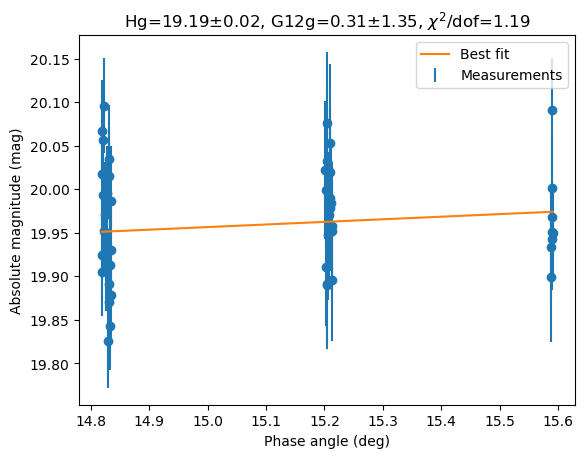

In [83]:
band = 'g'
df = sss[["unpacked_primary_provisional_designation", "ssObjectId", "phaseAngle", "topocentricDist", "heliocentricDist", "dia_band", "dia_psfMag", "dia_psfMagErr"]]
df = df.query("(unpacked_primary_provisional_designation == '2002 XO123') & (dia_band == @band)", engine="python")

H, G12, sigmaH, sigmaG12, covHG12, chi2dof, nobsv = \
    fitHG12(df["dia_psfMag"], df["dia_psfMagErr"], df["phaseAngle"], df["topocentricDist"], df["heliocentricDist"])

print(band, H, G12, sigmaH, sigmaG12, covHG12, chi2dof, nobsv)

# plot distance-corrected data
mag = df["dia_psfMag"]
mag1 = mag - 5. * np.log10(df["topocentricDist"]*df["heliocentricDist"])
p = df["phaseAngle"]
plt.scatter(p, mag1)
plt.errorbar(p, mag1, df["dia_psfMagErr"], ls='none',label='Measurements');

# overplot the model
_ph = sorted(df["phaseAngle"].to_numpy())
_mag = qa.HG12_model(np.deg2rad(_ph), (H, G12))
plt.plot(_ph, _mag, label='Best fit')
plt.xlabel('Phase angle (deg)',)
plt.ylabel('Absolute magnitude (mag)')
plt.legend()
plt.title(rf"H{band}={H:.2f}±{sigmaH:.2f}, G12{band}={G12:.2f}±{sigmaG12:.2f}, $\chi^2$/dof={chi2dof:.2f}", fontsize=12)


In [ ]:
# Extract the needed data from the DiaSource and SSSource tables
_sss = sss[["ssObjectId", "phaseAngle", "topocentricDist", "heliocentricDist", "dia_band", "dia_psfMag", "dia_psfMagErr"]]

j = 1
fig = plt.figure()
for band in ['g', 'r', 'i', 'z']:
    plt.subplot(2,2,j)
    mask = obsv['filter'] == band.encode('ascii')
    _obsv = obsv[mask]
    sss_this = _sss[mask]
    mag = _obsv["mag"]
    #mag = obsv["mag"]
    #print(pd.DataFrame(obsv))
    #print(pd.DataFrame(_sss))
    assert np.all(_obsv["filter"] == band.encode('ascii'))
    H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = \
        fitHG12(mag, _obsv["magSigma"], sss_this["phaseAngle"], sss_this["topocentricDist"], sss_this["heliocentricDist"])

    # plot distance-corrected data
    mag1 = mag -5. * np.log10(sss_this["topocentricDist"]*sss_this["heliocentricDist"])
    p = sss_this["phaseAngle"]
    plt.scatter(p, mag1)
    plt.errorbar(p, mag1, _obsv["magSigma"], ls='none',label='Measurements')

    # best-fit overplot
    _ph = sorted(p)
    _mag = HG12.evaluate(np.deg2rad(_ph), H, G, )
    plt.plot(_ph, _mag, label='Best fit')
    plt.xlabel('Phase angle (deg)',)
    plt.ylabel('Absolute magnitude (mag)', )
    plt.legend()
    plt.title(f"H{band}={H:.2f}±{sigmaH:.2f}, G12{band}={G:.2f}±{sigmaG:.2f}, $\chi^2$/dof={chi2dof:.2f}", fontsize=12)
    j+=1
fig.set_size_inches(12,12)
plt.tight_layout()

In [149]:
mask = sss["unpacked_primary_provisional_designation"] == b'5020 T-3'
pd.DataFrame(sss[mask])

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,heliocentricY,heliocentricZ,phaseAngle,ephOffsetDec,ephOffsetRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ,unpacked_primary_provisional_designation,ephVmag,ephRa,ephDec,ephRate,ephRateRa,ephRateDec,ephOffset,topocentricV,heliocentricV,ephOffsetAlongTrack,ephOffsetCrossTrack,elongation
0,24580699314978822,10.137464,183.336683,70.084445,285.999184,3.760479,2.063000,-12.923651,-4.442929,-3.660732,-0.840245,0.185011,0.0,0.014901,-0.021949,3472891268243346464,2.856502,-13.169429,10.797855,5.666604,-2.807131,-0.350274,0.396144,b'5020 T-3',0.0,187.110079,7.972389,0.061714,-0.058844,0.018603,0.026529,17.948202,13.820867,0.0,0.0,44.075867
1,24580699712389222,10.137434,183.336453,70.084449,285.998515,3.760479,2.063054,-12.923638,-4.442932,-3.660730,-0.840257,0.185007,0.0,-0.010530,-0.023859,3472891268243346464,2.856513,-13.173903,10.797553,5.666450,-2.807142,-0.350264,0.396149,b'5020 T-3',0.0,187.109858,7.972460,0.153304,-0.145892,0.047085,0.026080,17.951254,13.820864,0.0,0.0,44.076168
2,24580699982921779,10.137425,183.336298,70.084463,285.998068,3.760480,2.063090,-12.923631,-4.442934,-3.660729,-0.840264,0.185005,0.0,0.009643,-0.013972,3472891268243346464,2.856520,-13.176898,10.797331,5.666347,-2.807150,-0.350258,0.396152,b'5020 T-3',0.0,187.109711,7.972507,0.153308,-0.145908,0.047073,0.016976,17.953287,13.820863,0.0,0.0,44.076374
3,24580700385574940,10.137396,183.336059,70.084468,285.997372,3.760480,2.063147,-12.923617,-4.442937,-3.660727,-0.840277,0.185001,0.0,-0.017548,0.005944,3472891268243346464,2.856532,-13.181674,10.796941,5.666182,-2.807163,-0.350248,0.396158,b'5020 T-3',0.0,187.109476,7.972582,0.153431,-0.146019,0.047109,0.018528,17.956505,13.820859,0.0,0.0,44.076691
4,24580700821258247,10.137371,183.335820,70.084478,285.996678,3.760481,2.063201,-12.923605,-4.442940,-3.660725,-0.840288,0.184997,0.0,-0.014563,-0.018459,3472891268243346464,2.856543,-13.186156,10.796536,5.666028,-2.807174,-0.350238,0.396163,b'5020 T-3',0.0,187.109255,7.972652,0.153436,-0.146035,0.047101,0.023512,17.959503,13.820857,0.0,0.0,44.077000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,24633525650063371,9.918786,181.839156,70.035191,281.629364,3.764794,2.487377,-12.821256,-4.462658,-3.644870,-0.929995,0.153970,0.0,0.025883,-0.182636,3472891268243346464,2.960623,-17.823141,7.388928,4.156605,-2.914861,-0.288861,0.430619,b'5020 T-3',0.0,185.656983,8.364074,0.105643,-0.103969,0.018702,0.184461,19.736717,13.801702,0.0,0.0,46.153820
238,24633525835137034,9.918812,181.839167,70.035217,281.629402,3.764795,2.487398,-12.821251,-4.462659,-3.644870,-0.929999,0.153968,0.0,0.057235,0.115811,3472891268243346464,2.960629,-17.824596,7.387828,4.156522,-2.914867,-0.288858,0.430620,b'5020 T-3',0.0,185.656920,8.364085,0.105627,-0.103953,0.018694,0.129182,19.737602,13.801702,0.0,0.0,46.153847
239,24633526052716546,9.918763,181.839032,70.035179,281.629003,3.764795,2.487440,-12.821240,-4.462661,-3.644868,-0.930008,0.153965,0.0,0.010119,0.039903,3472891268243346464,2.960640,-17.827391,7.385695,4.156362,-2.914879,-0.288853,0.430623,b'5020 T-3',0.0,185.656798,8.364107,0.090474,-0.089055,0.016009,0.041166,19.739294,13.801700,0.0,0.0,46.154034
240,24633527151099907,9.918692,181.838519,70.035149,281.627512,3.764797,2.487607,-12.821198,-4.462668,-3.644861,-0.930043,0.153953,0.0,0.192328,0.024614,3472891268243346464,2.960689,-17.838602,7.376853,4.155713,-2.914928,-0.288833,0.430634,b'5020 T-3',0.0,185.656306,8.364194,0.105512,-0.103842,0.018662,0.193897,19.745977,13.801692,0.0,0.0,46.154781


In [110]:
from astropy.coordinates import get_body_barycentric_posvel, solar_system_ephemeris
import astropy.units as u
t = Time("2025-01-01T00:00:00", scale="tdb")

with solar_system_ephemeris.set("de440"):
    pos, vel = get_body_barycentric_posvel("sun", t)

vel.z.to(u.km/u.s).value

np.float64(-0.0027122465115513974)

In [28]:
t = Time(["2025-04-22T03:11:30", "2025-04-23T03:11:30"], scale="tt")  # or 'utc', etc.
r, v = observatory_barycentric_posvel("X05", t)

print("r (AU) =", r.value)
print("v (AU/day) =", v.value)

r (AU) = [[-0.85832852 -0.849389  ]
 [-0.49221191 -0.50560839]
 [-0.21319691 -0.21900458]]
v (AU/day) = [[ 0.00884304  0.00909561]
 [-0.01369764 -0.01355416]
 [-0.00583852 -0.00577666]]


In [125]:
v.to(u.km/u.s).value[2]

array([-10.10915062, -10.00203999])

In [248]:
jorbit.__file__

'/Users/mjuric/miniforge3/envs/ddpp-dev/lib/python3.14/site-packages/jorbit/__init__.py'

In [235]:
sss["ephRa"], dia[["mpc_provid", "ra"]]

(array([  0.        ,   0.        ,   0.        , ..., 185.65679841,
        185.65630646, 185.65497197], shape=(730877,)),
        mpc_provid          ra
 24125     1925 WG  186.012002
 27738     1925 WG  186.011483
 30686     1925 WG  186.004691
 30905     1925 WG  186.004442
 31258     1925 WG  186.004076
 ...           ...         ...
 615530   5020 T-3  185.656931
 615687   5020 T-3  185.656952
 615856   5020 T-3   185.65681
 616569   5020 T-3  185.656313
 618660   5020 T-3  185.655023
 
 [730877 rows x 2 columns])

## Serialization

In [87]:
struct_to_parquet(sss, f"{output_dir}/sssource.parquet")

In [88]:
struct_to_parquet(obj, f"{output_dir}/ssobject.parquet")

# Experiments

In [220]:
sss.dtype

dtype([('diaSourceId', '<u8'), ('eclipticBeta', '<f8'), ('eclipticLambda', '<f8'), ('galacticB', '<f8'), ('galacticL', '<f8'), ('heliocentricDist', '<f4'), ('heliocentricVX', '<f4'), ('heliocentricVY', '<f4'), ('heliocentricVZ', '<f4'), ('heliocentricX', '<f4'), ('heliocentricY', '<f4'), ('heliocentricZ', '<f4'), ('phaseAngle', '<f4'), ('ephOffsetDec', '<f4'), ('ephOffsetRa', '<f4'), ('ssObjectId', '<u8'), ('topocentricDist', '<f4'), ('topocentricVX', '<f4'), ('topocentricVY', '<f4'), ('topocentricVZ', '<f4'), ('topocentricX', '<f4'), ('topocentricY', '<f4'), ('topocentricZ', '<f4'), ('unpacked_primary_provisional_designation', 'S12'), ('ephVmag', '<f4'), ('ephRa', '<f8'), ('ephDec', '<f8'), ('ephRate', '<f4'), ('ephRateRa', '<f4'), ('ephRateDec', '<f4'), ('ephOffset', '<f4'), ('topocentricV', '<f4'), ('heliocentricV', '<f4'), ('ephOffsetAlongTrack', '<f4'), ('ephOffsetCrossTrack', '<f4'), ('elongation', '<f4')])

In [218]:
provID = "1935 MJ"
#provID = "1925 WG"

mask = sss["unpacked_primary_provisional_designation"] == provID.encode('ascii')
ephTimes = Time(dia["midpointMjdTai"][mask].values, format="mjd", scale="tai")

(packed, a, e, i, node, argperi, M, epoch) = mpcorb.query("unpacked_primary_provisional_designation == @provID", engine="python")["packed_primary_provisional_designation a e i node argperi mean_anomaly epoch_mjd".split()].iloc[0]

p = Particle.from_horizons(name=packed, time=Time(epoch, format="mjd", scale="tdb"))
eph = p.ephemeris(times=ephTimes, observer="rubin")
eph[:3]

<SkyCoord (ICRS): (ra, dec) in deg
    [(186.06054864, 7.8871594 ), (186.06030294, 7.88722324),
     (186.05820935, 7.8877665 )]>

In [219]:
dia[mask][["ra", "dec"]][:3]

,ra,dec
832,186.060546,7.887157
2868,186.060307,7.887222
15257,186.058209,7.887761


In [104]:
mpcorb.columns

Index(['id', 'packed_primary_provisional_designation',
       'unpacked_primary_provisional_designation', 'mpc_orb_jsonb',
       'created_at', 'updated_at', 'orbit_type_int', 'u_param', 'nopp',
       'arc_length_total', 'arc_length_sel', 'nobs_total', 'nobs_total_sel',
       'a', 'q', 'e', 'i', 'node', 'argperi', 'peri_time', 'yarkovsky', 'srp',
       'a1', 'a2', 'a3', 'dt', 'mean_anomaly', 'period', 'mean_motion',
       'a_unc', 'q_unc', 'e_unc', 'i_unc', 'node_unc', 'argperi_unc',
       'peri_time_unc', 'yarkovsky_unc', 'srp_unc', 'a1_unc', 'a2_unc',
       'a3_unc', 'dt_unc', 'mean_anomaly_unc', 'period_unc', 'mean_motion_unc',
       'epoch_mjd', 'h', 'g', 'not_normalized_rms', 'normalized_rms',
       'earth_moid', 'fitting_datetime'],
      dtype='object')

In [189]:
np.unique(sss["unpacked_primary_provisional_designation"])[:5]

array([b'1925 WG', b'1935 MJ', b'1971 XB', b'1977 TO6', b'1981 EY23'],
      dtype='|S12')

In [194]:
provID = "1935 MJ"
#provID = "1925 WG"

mask = sss["unpacked_primary_provisional_designation"] == provID.encode('ascii')
ephTimes = Time(dia["midpointMjdTai"][mask].values, format="mjd", scale="tai")

(packed, a, e, i, node, argperi, M, epoch) = mpcorb.query("unpacked_primary_provisional_designation == @provID", engine="python")["packed_primary_provisional_designation a e i node argperi mean_anomaly epoch_mjd".split()].iloc[0]

from jorbit.utils.kepler import kepler
nu = float(np.rad2deg(kepler(np.deg2rad(M), e)))

In [195]:
(packed, a, e, i, node, argperi, M, epoch, nu)

('J35M00J',
 2.7405712659089554,
 0.107450120786485,
 6.9204882983385,
 114.8424630478699,
 259.5145363529796,
 223.2683525717624,
 61000.0,
 215.60564366145016)

In [216]:
p = Particle.from_horizons(name="J35M00J", time=Time(61000.0, format="mjd", scale="tdb"))
print(p.keplerian_state)

KeplerianState(semi=Array([2.75126863], dtype=float64), ecc=Array([0.10606047], dtype=float64), inc=Array([6.91019815], dtype=float64), Omega=Array([114.83190949], dtype=float64), omega=Array([258.86133418], dtype=float64), nu=Array([216.28844803], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(2461000.5))


In [212]:
#def compute_ephemerides(provid, sss, dia):

# use ecliptic orbital elements
k = KeplerianState(
    semi=jnp.array([a]),
    ecc=jnp.array([e]),
    inc=jnp.array([i]),
    Omega=jnp.array([node]),
    omega=jnp.array([argperi]),
    nu=jnp.array([nu]),
    time=Time(epoch, format="mjd", scale="tdb").tdb.mjd,
    acceleration_func_kwargs={"c2": SPEED_OF_LIGHT**2}
)
#k = KeplerianState(semi=[2.75126863], ecc=Array([0.10606047], dtype=float64), inc=Array([6.91019815], dtype=float64), Omega=Array([114.83190949], dtype=float64), omega=Array([258.86133418], dtype=float64), nu=Array([216.28844803], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(2461000.5))
#p = Particle(name=provID, state=k)
p = Particle.from_horizons(name=packed, time=Time(epoch, format="mjd", scale="tdb"))

eph = p.ephemeris(times=ephTimes, observer="rubin")
eph[:3]

<SkyCoord (ICRS): (ra, dec) in deg
    [(186.06054864, 7.8871594 ), (186.06030294, 7.88722324),
     (186.05820935, 7.8877665 )]>

In [202]:
dia[mask][["ra", "dec"]][:3]

,ra,dec
832,186.060546,7.887157
2868,186.060307,7.887222
15257,186.058209,7.887761


In [197]:
eph[:3]

<SkyCoord (ICRS): (ra, dec) in deg
    [(185.88096421, 7.98200562), (185.88071887, 7.9820689 ),
     (185.8786284 , 7.9826074 )]>

In [157]:
from jorbit.utils.kepler import kepler
np.rad2deg(kepler(np.deg2rad(M), e))

np.float64(296.85433809191454)

In [146]:
mpcorb.query("unpacked_primary_provisional_designation == @provID", engine="python")

,unpacked_primary_provisional_designation,a,q,e,i,node,argperi,peri_time,mean_motion,epoch_mjd,h,g
1135052,1925 WG,2.198307,1.740068,0.208451,5.278014,147.080825,176.518447,59952.900288,0.302393,61000.0,11.984,0.15


In [213]:
k

KeplerianState(semi=Array([2.74057127], dtype=float64), ecc=Array([0.10745012], dtype=float64), inc=Array([6.9204883], dtype=float64), Omega=Array([114.84246305], dtype=float64), omega=Array([259.51453635], dtype=float64), nu=Array([215.60564366], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(61000.0))

In [214]:
p.keplerian_state

KeplerianState(semi=Array([2.75126863], dtype=float64), ecc=Array([0.10606047], dtype=float64), inc=Array([6.91019815], dtype=float64), Omega=Array([114.83190949], dtype=float64), omega=Array([258.86133418], dtype=float64), nu=Array([216.28844803], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(2461000.5))

In [185]:
import astropy.units as u

def query_horizons(provid, t, obscode="X05"):
    from astroquery.jplhorizons import Horizons
    from astroquery.jplsbdb import SBDB

    jd_utc = t.utc.jd
    # Do it in chunks, otherwise the query may get too long and fail
    chunk_size = 60
    ra, dec, delta, r, alpha = [], [], [], [], []
    for i in range(0, len(jd_utc), chunk_size):
        chunk = jd_utc[i:i+chunk_size]
        obj = Horizons(id=provid, id_type="smallbody", location=obscode, epochs=chunk)
        eph = obj.ephemerides(quantities="1,24,43,19,20", extra_precision=True).to_pandas()

        # note: I hate pandas.
        ra.append(eph["RA"].values)
        dec.append(eph["DEC"].values)
        delta.append(eph["delta"].values)
        r.append(eph["r"].values)
        alpha.append(eph["alpha"].values)
    return tuple(np.concat(x) for x in (ra, dec, delta, r, alpha))

(ra, dec) = query_horizons(provID.decode('utf-8'), ephTimes)[:2]
ra[:3], dec[:3]

(array([186.01200051, 186.01148191, 186.00468842]),
 array([4.36829809, 4.36851982, 4.37142244]))

In [29]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord

import jorbit
from jorbit.utils.states import KeplerianState
from jorbit.data.constants import SPEED_OF_LIGHT
from jorbit import Particle

In [30]:
p = Particle.from_horizons(name="274301", time=Time("2025-01-01"))
eph = p.ephemeris(
    times=Time(["2025-01-01", "2025-01-02", "2025-01-03"]),
    observer="kitt peak"
)
eph

(<SkyCoord (ICRS): (ra, dec) in deg
     [(153.72964717, 3.87795531), (153.68822891, 3.87901708),
      (153.64036499, 3.88301024)]>,
 Array([[-2.00377975,  1.7805335 ,  0.52033509],
        [-2.01043358,  1.77389939,  0.51829466],
        [-2.01705825,  1.76723942,  0.51624667]], dtype=float64),
 Array([[-0.00666839, -0.00662115, -0.00203664],
        [-0.00663927, -0.00664706, -0.00204422],
        [-0.00661005, -0.00667287, -0.00205176]], dtype=float64),
 Array([[-0.18439221,  0.88262367,  0.38282952],
        [-0.20156054,  0.87955219,  0.38149742],
        [-0.21866688,  0.87620439,  0.3800454 ]], dtype=float64))

In [16]:
import numpy as np
x, y, z = np.array(eph[1]).T

array([-2.00377975, -2.01043358, -2.01705825])

In [91]:
# use ecliptic orbital elements
k = KeplerianState(
    semi=jnp.array([2.3785863410573236]),
    ecc=jnp.array([0.14924976664546713]),
    inc=jnp.array([6.733641114294506]),
    Omega=jnp.array([183.37291068678854]),
    omega=jnp.array([140.26341029272996]),
    nu=jnp.array([173.59627946476093]),
    time=Time("2025-01-01").tdb.jd,
    acceleration_func_kwargs={"c2": SPEED_OF_LIGHT**2}
)
p = Particle(name="(274301) Wikipedia", state=k)

In [101]:
eph = p.ephemeris(
    times=Time(["2025-01-01", "2025-01-02", "2025-01-03"]),
    observer="rubin"
)
eph

<SkyCoord (ICRS): (ra, dec) in deg
    [(153.73023907, 3.87921287), (153.68881662, 3.88028218),
     (153.64094818, 3.8842829 )]>

# Old bits and pieces

In [24]:
def _createDiaSourceTable_mapper(item):
    fn, size, offset = item
    import time, sys

    # load
    t0 = time.perf_counter()
    print(fn)
    try:
        det = pd.read_hdf(fn).reset_index()
        #det = det.drop_duplicates('observationId')
    except:
        print("ERROR: ", fn)
        return (fn, 0)
    t_read = time.perf_counter() - t0

    # convert DiaSource
    #det = det.drop_duplicates('observationId')
    df = convertToDiaSource(det)
    arr = np.asarray(df.to_records(index=False, column_dtypes={"filter": "S1"}))
    assert size == arr.size

    # a very simple checksum
    cksum = df["ccdVisitId"].sum()

    # store to array
    t0 = time.perf_counter()
    dia[offset:offset + size] = arr
    t_write = time.perf_counter() - t0

    #
    # construct SSSource
    #
    # FIXME: this should all be _computed_ from the orbit, not taken from the simulated inputs
    ss = sss[offset:offset + size]
    ss["ssObjectId"] = df["ssObjectId"].values
    ss["diaSourceId"] = df["diaSourceId"].values
    ss["mpcUniqueId"] = 0

    from astropy.coordinates import SkyCoord, HeliocentricEclipticIAU76
    import astropy.units as u
    p = SkyCoord(ra=det["AstRA(deg)"].values*u.deg, dec=det["AstDec(deg)"].values*u.deg, distance=1*u.au, frame='hcrs')
    ecl = p.transform_to(HeliocentricEclipticIAU76)
    p = SkyCoord(ra=det["AstRA(deg)"].values*u.deg, dec=det["AstDec(deg)"].values*u.deg, distance=1*u.au, frame='icrs')
    gal = p.transform_to('galactic')

    ss["eclipticLambda"] = ecl.lon
    ss["eclipticBeta"] = ecl.lat
    ss["galacticL"] = gal.l
    ss["galacticB"] = gal.b

    au = (u.AU).to(u.km)
    au_day = (u.AU / u.day).to(u.km / u.s)

    ss["phaseAngle"] = det["Sun-Ast-Obs(deg)"]
    ss['predictedMagnitude'] = np.nan
    ss['predictedMagnitudeSigma'] = np.nan
    ss['residualRa'] = np.nan
    ss['residualDec'] = np.nan
    ss['predictedRaSigma'] = np.nan
    ss['predictedDecSigma'] = np.nan
    ss['predictedRaDecCov'] = np.nan
    ss['heliocentricX'] = det["Ast-Sun(J2000x)(km)"].values / au
    ss['heliocentricY'] = det["Ast-Sun(J2000y)(km)"].values / au
    ss['heliocentricZ'] = det["Ast-Sun(J2000z)(km)"].values / au
    ss['heliocentricVX'] = det["Ast-Sun(J2000vx)(km/s)"].values / au_day
    ss['heliocentricVY'] = det["Ast-Sun(J2000vy)(km/s)"].values / au_day
    ss['heliocentricVZ'] = det["Ast-Sun(J2000vz)(km/s)"].values / au_day
    ss['topocentricX'] = (det["Ast-Sun(J2000x)(km)"].values - det["Obs-Sun(J2000x)(km)"].values) / au
    ss['topocentricY'] = (det["Ast-Sun(J2000y)(km)"].values - det["Obs-Sun(J2000y)(km)"].values) / au
    ss['topocentricZ'] = (det["Ast-Sun(J2000z)(km)"].values - det["Obs-Sun(J2000z)(km)"].values) / au
    ss['topocentricVX'] = (det["Ast-Sun(J2000vx)(km/s)"].values - det["Obs-Sun(J2000vx)(km/s)"].values) / au_day
    ss['topocentricVY'] = (det["Ast-Sun(J2000vy)(km/s)"].values - det["Obs-Sun(J2000vy)(km/s)"].values) / au_day
    ss['topocentricVZ'] = (det["Ast-Sun(J2000vz)(km/s)"].values - det["Obs-Sun(J2000vz)(km/s)"].values) / au_day
    ss['heliocentricDist'] = np.sqrt(ss['heliocentricX']**2 + ss['heliocentricY']**2 + ss['heliocentricZ']**2)
    ss['topocentricDist'] = np.sqrt(ss['topocentricX']**2 + ss['topocentricY']**2 + ss['topocentricZ']**2)

    return (fn, len(df), cksum, (t_read, t_write))

def createDiaSourceTable(inputs):
    import os
    from functools import partial
    from tqdm.notebook import tqdm

    from multiprocessing import Pool
    with Pool(10) as p:
        outputs = list(tqdm(
            p.imap(
                _createDiaSourceTable_mapper, inputs.itertuples(index=False, name=None)
            ), total=len(inputs)
        ))

    nrows = sum(i for _, i, _, _ in outputs)
    cksum = sum(i for _, _, i, _ in outputs)
    
    return nrows, cksum, outputs

nrows, cksum, outputs = createDiaSourceTable(inputs)
#_createDiaSourceTable_mapper(tuple(inputs.loc[0]))

print(f"Converted {nrows} rows (checksum={cksum}).")

/data3/epyc/data3/jake_dp03//combined/hybrid_s3m_3.hdf/data3/epyc/data3/jake_dp03//combined/iso_spaceship.hdf/data3/epyc/data3/jake_dp03//combined/isos.hdf/data3/epyc/data3/jake_dp03//combined/com_spaceship.hdf/data3/epyc/data3/jake_dp03//combined/hybrid_mpcorb.hdf

  0%|          | 0/10 [00:00<?, ?it/s]

/data3/epyc/data3/jake_dp03//combined/LPCC.hdf/data3/epyc/data3/jake_dp03//combined/hybrid_s3m_2.hdf/data3/epyc/data3/jake_dp03//combined/LPCD.hdf/data3/epyc/data3/jake_dp03//combined/neo_spaceship.hdf
/data3/epyc/data3/jake_dp03//combined/hybrid_s3m_1.hdf








Converted 653005444 rows (checksum=725107911534562).


A quick-and-dirty check that everything went well:

In [25]:
%%time
cksum2 = dia["ccdVisitId"].sum()
cksum2

CPU times: user 8.15 s, sys: 22 s, total: 30.1 s
Wall time: 30.2 s


725107911534562

In [26]:
assert cksum == cksum2

## Let's find all unique objects

Need to find all unique objects in the input, as we'll be generating the SSObject table object by object. This is what pandas.groupby() does in the background, but Pandas is too slow and RAM-inefficient to be useful here so we'll have to do it old school.

Optimization: Load the saved indices if you've already generated them, or skip the next cell and execute the cells below to create it.

In [ ]:
'''import pickle
with open(f"{output_dir}/indices.pkl", "rb") as ff:
    i = pickle.load(ff)
    del i
    ssObjectId = pickle.load(ff)
    del ssObjectId
    ssObjects = pickle.load(ff)
    del ssObjects
    splits = pickle.load(ff)
    nobj = pickle.load(ff)'''

Execute these cells to build the necessary indices. If you've successfully run the cell above, DONT RUN THESE.

In [27]:
%%time
dia.sort(kind='stable', order='ssObjectId')

CPU times: user 1h 1min 26s, sys: 14min, total: 1h 15min 27s
Wall time: 1h 10min 41s


In [28]:
%%time
sss.sort(kind='stable', order='ssObjectId')

CPU times: user 39min 23s, sys: 20min 17s, total: 59min 41s
Wall time: 56min 51s


In [ ]:
#%%time
#assert np.all(dia["diaSourceId"] == sss["diaSourceId"])

In [29]:
%%time
# i is an ndarray that would sort `dia` by ssObjectId
# this takes about ~10 minutes on epyc
i = np.argsort(dia["ssObjectId"], kind='stable')

CPU times: user 12.9 s, sys: 20.6 s, total: 33.4 s
Wall time: 33.5 s


In [30]:
%%time
# a sorted list of ssObjectIds
# this takes 2-3 minutes on epyc
ssObjectId = dia["ssObjectId"][i]

CPU times: user 8.5 s, sys: 2.48 s, total: 11 s
Wall time: 11 s


In [31]:
%%time
# a list of unique ssObjects, and an index idx of the row in ssObjectId where the corresponding entry
# in ssObject appears first. This is useful for groupby type operations.
ssObjects, idx = np.unique(ssObjectId, return_index=True)

CPU times: user 6.27 s, sys: 8.34 s, total: 14.6 s
Wall time: 14.8 s


In [32]:
%%time
# create the "group by" splits for individual objects (takes ~1 minute on epyc)
# See https://stackoverflow.com/a/43094244 for inspiration for this code
#
# (ssObjects, splits) are a 1:1 map -- for each ssObject, the corresponding entry in
# splits are the indices in dia where its rows are.
#
# FIXME: should this be a dict (?)
splits = np.split(i, idx[1:])
assert len(splits) == ssObjects.size

CPU times: user 10.4 s, sys: 801 ms, total: 11.2 s
Wall time: 11.2 s


In [33]:
nobj = len(ssObjects)

In [35]:
print(nobj)

4443479


In [43]:
closeArray(dia_mm, dia_fp)

In [45]:
closeArray(sss_mm, sss_fp)

In [10]:
dia, dia_mm, dia_fp = openOrCreateArray(diaFn, nrows, arr.dtype)

Opening existing file outputs/dp0.3_jun2023//diaSource.npy


In [11]:
sss, sss_mm, sss_fp = openOrCreateArray(sssFn, nrows, ssSourceDtype)

Opening existing file outputs/dp0.3_jun2023//ssSource.npy


In [13]:
dia['nameTrue']

array([b'2012 AA35', b'2012 AA35', b'2012 AA35', ..., b'S100Lwxta',
       b'S100Lwxta', b'S100Lwxta'], dtype='|S16')

Write out the results so we can recover quickly if the kernel is restarted.

In [46]:
import pickle
with open(f"{output_dir}/indices.pkl", "wb") as ff:
    pickle.dump(i, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjectId, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjects, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(splits, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(nobj, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
import pickle
with open(f"{output_dir}/splits.pkl", "wb") as ff:
    pickle.dump(splits, ff, protocol=pickle.HIGHEST_PROTOCOL)

The cell below loads the tables if needed

In [12]:
import pickle
with open(f"{output_dir}/indices.pkl", "rb") as ff:
    i = pickle.load(ff)
    ssObjectsId = pickle.load(ff)
    ssObjects = pickle.load(ff)
    splits = pickle.load(ff)
    nobj = pickle.load(ff)

## Linking will go here

## Orbit fitting

Let's generate some files in the `ADES` format to integrate with orbit fitting

In [40]:
len(ssObjects)

4443479

In [ ]:
from astropy.time import Time

def write_to_ades(chunk_begin, chunk_size, filename):
    chunk_end = min(len(ssObjects)-1, chunk_begin + chunk_size)
    split_array = splits[chunk_begin : chunk_end]
    detections = np.concatenate(split_array)
    
    dia_this = pd.DataFrame(dia[detections])
    
    dia_this = dia_this.sort_values('ssObjectId')
    
    #rename columns
    dia_this['rmsRA'] = dia_this['raSigma']
    dia_this['dec'] = dia_this['decl']
    dia_this['rmsDec'] = dia_this['declSigma']
    dia_this['rmsMag'] = dia_this['magSigma']
    dia_this['band'] = dia_this['filter'].astype('str')
    
    dia_this['obsTime'] = [i + 'Z' for i in Time(dia_this['midPointTai'], format='mjd', scale='tai').utc.isot]
    dia_this['stn'] = 'I11'
    dia_this['mode'] = 'CCD'
    dia_this['astCat'] = 'Gaia2'
    
    dia_this['trkSub'] = dia_this['ssObjectId'].astype('str')
    
    dia_this = dia_this[['trkSub', 'obsTime', 'ra', 'dec', 'rmsRA', 'rmsDec',
                        'mag', 'rmsMag','band','stn', 'mode','astCat']]
    
    
    with open(filename, 'w') as f:
        #long string to avoid whitespace problems
        f.write("# version=2017\n! mpcCode I11\n# submitter\n! name D. iRAC\n# telescope\n! aperture 8.4\n! design Reflector\n! detector CCD\n# observers\n! name D. iRAC# measurers\n! name D. iRAC\n")
    dia_this.to_csv(filename, mode='a', sep='|',index=False)
    
    
    

In [ ]:
write_to_ades(0, 10_000, 'test.psv')

## Build the MPCORB Table

Just read and reformat the S3M files (quick and dirty). Load everything into RAM (it's small).

In [ ]:
def load_mpcorb_ssm():
    dtyp={
        "id": str,
        "q": 'f8',
        "e": 'f8',
        "i": 'f8',
        "O": 'f8',
        "o": 'f8',
        "tp": 'f8',
        "H": 'f4',
        "epoch": 'f8'
    }
    usecols=["id", "q", "e", "i", "O", "o", "tp", "H", "epoch"]
    df = pd.read_csv("orbits/mpcorb_20220222_COM.ssm", header=None, skiprows=1,
                     names="q e i O o tp epoch H id".split(), 
                     usecols=usecols,
                     dtype=dtyp, delim_whitespace=True)
    df["format"] = "COM"
    return df

In [ ]:
names=["id", "format", "q", "e", "i", "O", "o", "tp", "H", "epoch", "idx", "npar", "moid", "cc"]
usecols=["id", "format", "q", "e", "i", "O", "o", "tp", "H", "epoch"]
dtyp={
    "id": str,
    "format": str,
    "q": 'f8',
    "e": 'f8',
    "i": 'f8',
    "O": 'f8',
    "o": 'f8',
    "tp": 'f8',
    "H": 'f4',
    "epoch": 'f8'
}

dfs = []
from tqdm.notebook import tqdm
mpcinputs = glob.glob("orbits/S3M_v09.05.15/S*.s3m")
mpcinputs.remove("orbits/S3M_v09.05.15/SH.s3m") # FIXME: this one has duplicate names with S0 (???)
for fn in tqdm(mpcinputs):
    try:
        df = pd.read_csv(fn, header=None, skiprows=2, names=names, usecols=usecols, dtype=dtyp, delim_whitespace=True)
    except ValueError:
        # some files have an extra column
        df = pd.read_csv(fn, header=None, skiprows=2, names=names + ["_"], usecols=usecols, dtype=dtyp, delim_whitespace=True)
    dfs.append(df)

if load_mpcorb:
    dfs.append(load_mpcorb_ssm())

df = pd.concat(dfs)
del dfs

nmpc = len(df)
print(f"Loaded {nmpc} rows")
df

In [20]:
import glob
elementfiles = glob.glob(f'{input_dir}/initial_files/*.fits')
elementfiles

['/data3/epyc/data3/jake_dp03//initial_files/hybrid.fits',
 '/data3/epyc/data3/jake_dp03//initial_files/iso.fits',
 '/data3/epyc/data3/jake_dp03//initial_files/lpcc.fits',
 '/data3/epyc/data3/jake_dp03//initial_files/lpcd.fits']

In [49]:
import astropy.table as tb
elements = []
for i in elementfiles:
    a = tb.Table.read(i)
    if 'Name' in a.keys():
        a.rename_column('Name', 'name')
    a = tb.unique(a, keys='name')
    elements.append(a)
elements = tb.vstack(elements)

In [50]:
elements

id,t_0,H,g,name,a,e,i,O,o,q,M,t_peri,FORMAT,x,y,z,xdot,ydot,zdot,Epoch,Index,N_PAR,MOID,COMPCODE,color,sed_filename
float64,float64,float64,float64,bytes10,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,bytes1,bytes1
9496.0,60065.0,13.63,0.15,1001 T-2,2.9394943137717573,0.10364706261620862,2.2561700000000937,178.99414999999973,263.84765957827295,2.634824362572267,-140.07597623085252,60780.776343854406,--,--,--,--,--,--,--,--,--,--,--,--,--,--
29039.0,60065.0,16.07,0.15,1002 T-2,2.3178047394493957,0.1096100027249522,1.559869999999921,7.454070000000007,20.067975305667133,2.06375015564244,-14.33811702997599,60116.29938247195,--,--,--,--,--,--,--,--,--,--,--,--,--,--
18234.0,60065.0,14.13,0.15,1003 T-2,3.098714346286973,0.1457097837699353,0.7274499999999973,216.03506999999996,265.5617036277736,2.647201348924702,-58.31762599037114,60387.53503557341,--,--,--,--,--,--,--,--,--,--,--,--,--,--
52162.0,60065.0,15.33,0.15,1004 T-2,2.572467636696775,0.04518776087460034,6.90619000000002,356.82331,20.381252193850084,2.456223584272073,-16.619605689829257,60134.52649591891,--,--,--,--,--,--,--,--,--,--,--,--,--,--
90644.0,60065.0,14.86,0.15,1004 T-3,2.991539332261167,0.22693445141662902,8.370260000000036,280.51222,43.56846836477106,2.3126559950032104,-40.108672912269355,60275.419078807856,--,--,--,--,--,--,--,--,--,--,--,--,--,--
20936.0,60065.0,13.98,0.15,1005 T-2,3.0272359461083544,0.09348065220065134,2.197759999999897,207.02594000000002,166.32443141841594,2.7442479555008896,134.04900139173182,59349.1241083727,--,--,--,--,--,--,--,--,--,--,--,--,--,--
96085.0,60065.0,13.82,0.15,1006 T-2,3.967646449021817,0.12093844027392477,4.945129999999978,194.29654000000002,116.56276097549573,3.487805475918742,167.4498506972164,58723.196377594366,--,--,--,--,--,--,--,--,--,--,--,--,--,--
90620.0,60065.0,15.61,0.15,1007 T-2,2.48682530570372,0.10309061262198531,3.2175299999999356,215.68254,136.99692879468614,2.230456961454868,-126.91363396288074,60569.63915356059,--,--,--,--,--,--,--,--,--,--,--,--,--,--
34952.0,60065.0,14.61,0.15,1008 T-2,3.0895582997098034,0.12434943074606118,11.206810000000031,350.49222,48.47934339440299,2.7053734838841206,8.77710029452418,60016.6718245247,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [85]:
#going to pandas for convencience with some functions
df = tb.Table.to_pandas(elements)
df

,id,t_0,H,g,name,a,e,i,O,o,q,M,t_peri,FORMAT,x,y,z,xdot,ydot,zdot,Epoch,Index,N_PAR,MOID,COMPCODE,color,sed_filename
0,9496.0,60065.000000,13.63,0.15,b'1001 T-2',2.939494,0.103647,2.256170,178.994150,263.847660,2.634824,-140.075976,60780.776344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN
1,29039.0,60065.000000,16.07,0.15,b'1002 T-2',2.317805,0.109610,1.559870,7.454070,20.067975,2.063750,-14.338117,60116.299382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN
2,18234.0,60065.000000,14.13,0.15,b'1003 T-2',3.098714,0.145710,0.727450,216.035070,265.561704,2.647201,-58.317626,60387.535036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN
3,52162.0,60065.000000,15.33,0.15,b'1004 T-2',2.572468,0.045188,6.906190,356.823310,20.381252,2.456224,-16.619606,60134.526496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN
4,90644.0,60065.000000,14.86,0.15,b'1004 T-3',2.991539,0.226934,8.370260,280.512220,43.568468,2.312656,-40.108673,60275.419079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14462383,NaN,59741.783047,15.00,NaN,b'LPCD995',NaN,0.707848,115.835455,330.101113,318.539718,19.757014,NaN,59739.433321,b'COM',NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,-1,b'Python',b'S',b'C'
14462384,NaN,62240.976261,15.00,NaN,b'LPCD996',NaN,0.746319,87.698477,95.872189,295.966035,13.547584,NaN,62240.948860,b'COM',NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,-1,b'Python',b'S',b'C'
14462385,NaN,62538.440459,15.00,NaN,b'LPCD997',NaN,0.601924,42.004673,281.117366,271.001802,14.903283,NaN,62537.517958,b'COM',NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,-1,b'Python',b'S',b'C'
14462386,NaN,61816.341610,15.00,NaN,b'LPCD998',NaN,0.562721,22.686371,325.195817,153.688724,17.957339,NaN,61816.340657,b'COM',NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,-1,b'Python',b'S',b'C'


Quick sanity checks

In [52]:
assert df["i"].min() >= 0 and df["i"].max() < 180
assert df["O"].min() >= 0 and df["O"].max() <= 360, (df["O"].min(), df["O"].max())
assert df["o"].min() >= 0 and df["o"].max() <= 360, (df["o"].min(), df["o"].max())

In [53]:
# There should be no duplicate names
mask = df[["name"]].duplicated(keep=False)
#assert np.any(mask) == False, "Duplicate names! Uncomment the next line to debug"
df[mask].sort_values(by='id')

,id,t_0,H,g,name,a,e,i,O,o,q,M,t_peri,FORMAT,x,y,z,xdot,ydot,zdot,Epoch,Index,N_PAR,MOID,COMPCODE,color,sed_filename


MPCORB schema

In [54]:
mpcorbDtype = np.dtype([
    ('mpcDesignation', 'S16'),
    ('mpcNumber', 'i4'),
    ('ssObjectId', 'u8'),
    ('mpcH', 'f4'),
    ('mpcG', 'f4'),
    ('epoch', 'f8'),
    ('tperi', 'f8'),
    ('peri', 'f8'),
    ('node', 'f8'),
    ('incl', 'f8'),
    ('e', 'f8'),
    ('n', 'f8'),
    ('q', 'f8'),
    ('uncertaintyParameter', 'S1'),
    ('reference', 'S9'),
    ('nobs', 'i4'),
    ('nopp', 'i4'),
    ('arc', 'f4'),
    ('arcStart', 'f8'),
    ('arcEnd', 'f8'),
    ('rms', 'f4'),
    ('pertsShort', 'S3'),
    ('pertsLong', 'S3'),
    ('computer', 'S10'),
    ('flags', 'i4'),
    ('fullDesignation', 'S26'),
    ('lastIncludedObservation', 'f4')
])
mpcorbDtype.itemsize

192

In [55]:
nmpc = len(df)

Create the table on disk:

In [56]:
mpc, mpc_mm, mpc_fp = openOrCreateArray(mpcFn, nmpc, mpcorbDtype)

Populate it with the dataframe contents:

In [86]:
mpc["mpcDesignation"] = df["name"].values.astype('str')
mpc["mpcNumber"] = 0
mpc["ssObjectId"] = df["name"].astype('str').apply(hashTo64).astype('uint64').values
mpc["mpcH"] = df["H"].values
mpc["mpcG"] = 0.15  # FIXME: check what we actually used? # answer: 0.15... 
mpc["epoch"] = df["t_0"].values
mpc["tperi"] = df["t_peri"].values
mpc["peri"] = df["o"].values
mpc["node"] = df["O"].values
mpc["incl"] = df["i"].values
mpc["e"] = df["e"].values
mpc["q"] = df["q"].values

In [87]:
mpc["n"] = np.nan
mpc["arc"] = np.nan
mpc["arcStart"] = np.nan
mpc["arcEnd"] = np.nan
mpc["rms"] = np.nan
mpc["lastIncludedObservation"] = np.nan

In [88]:
mpc["fullDesignation"] = np.char.add("2011 ", df["name"].values.astype('str'))

In [89]:
pd.DataFrame(mpc[:10])

,mpcDesignation,mpcNumber,ssObjectId,mpcH,mpcG,epoch,tperi,peri,node,incl,e,n,q,uncertaintyParameter,reference,nobs,nopp,arc,arcStart,arcEnd,rms,pertsShort,pertsLong,computer,flags,fullDesignation,lastIncludedObservation
0,b'1001 T-2',0,9533584092189618771,13.63,0.15,60065.0,60780.776344,263.847660,178.99415,2.25617,0.103647,NaN,2.634824,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1001 T-2',NaN
1,b'1002 T-2',0,6203778644188667635,16.07,0.15,60065.0,60116.299382,20.067975,7.45407,1.55987,0.109610,NaN,2.063750,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1002 T-2',NaN
2,b'1003 T-2',0,15444692206197497326,14.13,0.15,60065.0,60387.535036,265.561704,216.03507,0.72745,0.145710,NaN,2.647201,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1003 T-2',NaN
3,b'1004 T-2',0,2844359012889597252,15.33,0.15,60065.0,60134.526496,20.381252,356.82331,6.90619,0.045188,NaN,2.456224,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1004 T-2',NaN
4,b'1004 T-3',0,10081687484759141720,14.86,0.15,60065.0,60275.419079,43.568468,280.51222,8.37026,0.226934,NaN,2.312656,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1004 T-3',NaN
5,b'1005 T-2',0,7666959711836374386,13.98,0.15,60065.0,59349.124108,166.324431,207.02594,2.19776,0.093481,NaN,2.744248,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1005 T-2',NaN
6,b'1006 T-2',0,8582309112211663112,13.82,0.15,60065.0,58723.196378,116.562761,194.29654,4.94513,0.120938,NaN,3.487805,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1006 T-2',NaN
7,b'1007 T-2',0,9672110062849154568,15.61,0.15,60065.0,60569.639154,136.996929,215.68254,3.21753,0.103091,NaN,2.230457,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1007 T-2',NaN
8,b'1008 T-2',0,5461598545076154580,14.61,0.15,60065.0,60016.671825,48.479343,350.49222,11.20681,0.124349,NaN,2.705373,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1008 T-2',NaN
9,b'1008 T-3',0,15902559303314459215,15.01,0.15,60065.0,59455.761745,144.853004,231.35950,12.60331,0.169675,NaN,2.583590,b'',b'',0,0,NaN,NaN,NaN,NaN,b'',b'',b'',0,b'2011 1008 T-3',NaN


In [90]:
mpc_a = mpc['q']/(1-mpc['e'])


In [91]:
np.max(mpc['q'])

80.49300961914675

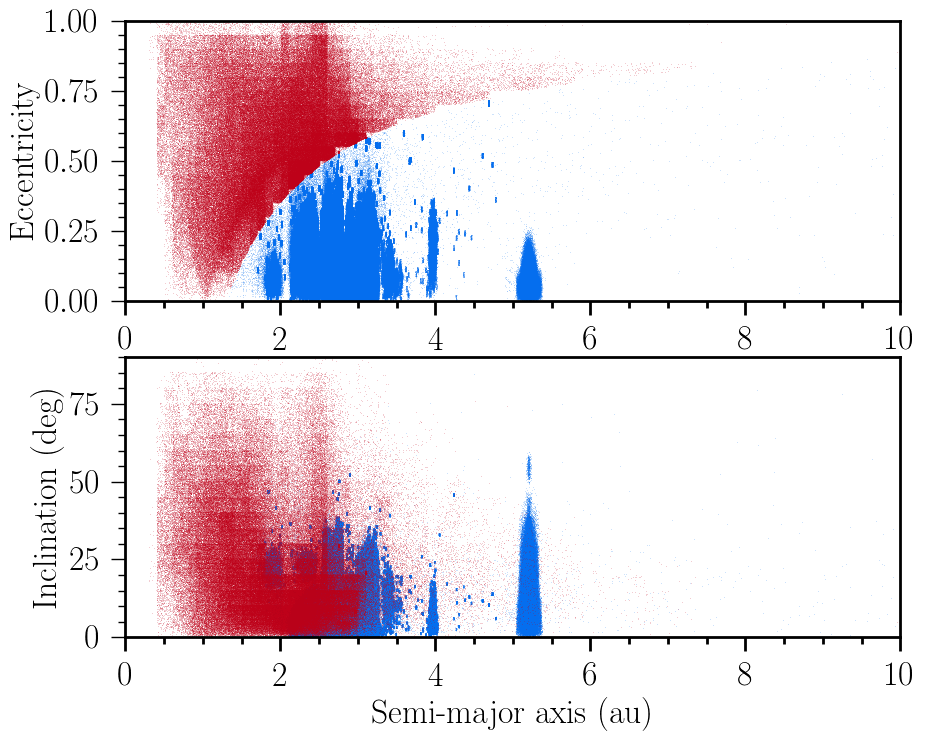

In [63]:

plt.subplot(2,1,1)
#plt.hexbin(mpc_a[mpc['q'] > 1.3], mpc['e'][mpc['q'] > 1.3], bins='log', gridsize=1000)
plt.plot(mpc_a[mpc['q'] > 1.3], mpc['e'][mpc['q'] > 1.3], ',', alpha=0.2)
plt.plot(mpc_a[mpc['q'] < 1.3], mpc['e'][mpc['q'] < 1.3], ',', alpha=0.2)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Semi-major axis (au)')
plt.ylabel('Eccentricity')


plt.subplot(2,1,2)
plt.plot(mpc_a[mpc['q'] > 1.3], mpc['incl'][mpc['q'] > 1.3], ',', alpha=0.2)
plt.plot(mpc_a[mpc['q'] < 1.3], mpc['incl'][mpc['q'] < 1.3], ',',alpha=0.2)
plt.xlim(0,10)
plt.ylim(0,90)
plt.xlabel('Semi-major axis (au)')
plt.ylabel('Inclination (deg)')


plt.show()

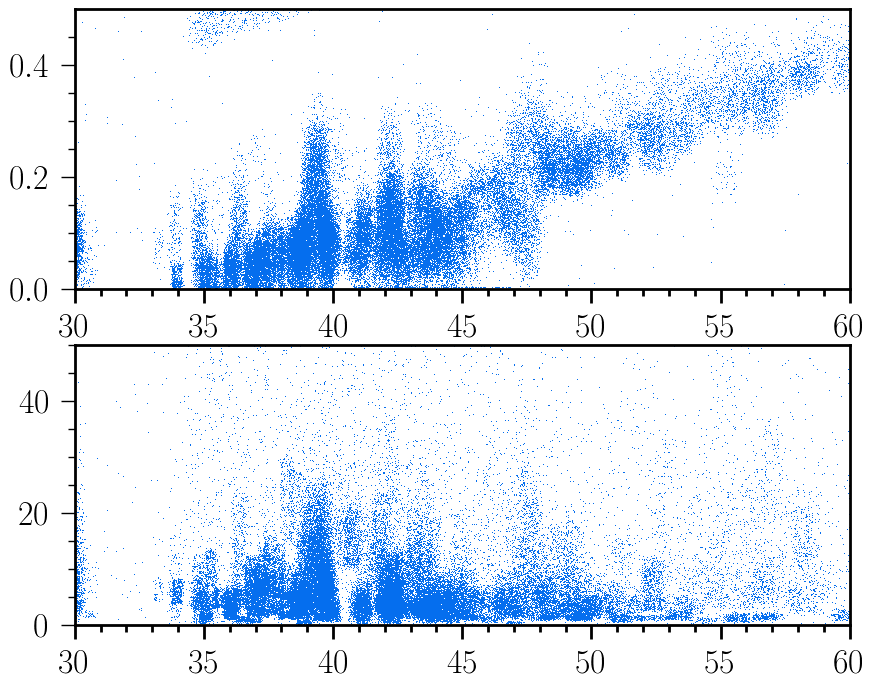

In [64]:
plt.subplot(2,1,1)
plt.plot(mpc_a[mpc_a>0], mpc['e'][mpc_a>0], ',', )
#plt.xscale('log')
plt.xlim(30,60)
plt.ylim(0, 0.5)
plt.subplot(2,1,2)
plt.plot(mpc_a[mpc_a>0], mpc['incl'][mpc_a>0], ',')
#plt.xscale('log')
plt.xlim(30,60)
plt.ylim(0,50)
plt.show()

See if there are any objects in ssObjects that aren't in the catalog - spaceships should be here!

In [65]:
ok = pd.Series(ssObjects).isin(mpc['ssObjectId'])
ok.all()


False

In [92]:
mpc[mpc['mpcDesignation'].astype('str') == 'LPCD4883']

array([(b'LPCD4883', 0, 10189831101851822009, 15., 0.15, 59875.29994257, 59875.283841, 299.80120186, 280.6727757, 15.04427227, 0.93408273, nan, 2.9093417, b'', b'', 0, 0, nan, nan, nan, nan, b'', b'', b'', 0, b'2011 LPCD4883', nan)],
      dtype=[('mpcDesignation', 'S16'), ('mpcNumber', '<i4'), ('ssObjectId', '<u8'), ('mpcH', '<f4'), ('mpcG', '<f4'), ('epoch', '<f8'), ('tperi', '<f8'), ('peri', '<f8'), ('node', '<f8'), ('incl', '<f8'), ('e', '<f8'), ('n', '<f8'), ('q', '<f8'), ('uncertaintyParameter', 'S1'), ('reference', 'S9'), ('nobs', '<i4'), ('nopp', '<i4'), ('arc', '<f4'), ('arcStart', '<f8'), ('arcEnd', '<f8'), ('rms', '<f4'), ('pertsShort', 'S3'), ('pertsLong', 'S3'), ('computer', 'S10'), ('flags', '<i4'), ('fullDesignation', 'S26'), ('lastIncludedObservation', '<f4')])

In [93]:
hashTo64('LPCD4883')

10189831101851822009

In [95]:
closeArray(mpc_mm, mpc_fp)

In [94]:
ssObjects[np.isin(ssObjects, mpc['ssObjectId'])]

array([       2150553186630,        3369984299447,        5992863104062,
       ..., 18446736273415404595, 18446738948979404594,
       18446740198085090431], dtype=uint64)

## Compute the SSObjects Table

Let's define the schema of our SSObjects table.

Note that `lcPeriodic` is commented out due to data type

In [14]:
ssObjectDtype = np.dtype([
    ('ssObjectId', 'u8'),
    ('discoverySubmissionDate', 'f8'), #mjd of exp
    ('firstObservationDate', 'f8'),
    ('arc', 'f4'),
    ('numObs', 'u4'),
    #('lcPeriodic', 'b768'),
    ('MOID', 'f4'), #we don't have these yet
    ('MOIDTrueAnomaly', 'f4'),
    ('MOIDEclipticLongitude', 'f4'),
    ('MOIDDeltaV', 'f4'),
    ('uH', 'f4'),
    ('uG12', 'f4'),
    ('uHErr', 'f4'),
    ('uG12Err', 'f4'),
    ('uH_uG12_Cov', 'f4'),
    ('uChi2', 'f4'),
    ('uNdata', 'u4'),
    ('gH', 'f4'),
    ('gG12', 'f4'),
    ('gHErr', 'f4'),
    ('gG12Err', 'f4'),
    ('gH_gG12_Cov', 'f4'),
    ('gChi2', 'f4'),
    ('gNdata', 'u4'),
    ('rH', 'f4'),
    ('rG12', 'f4'),
    ('rHErr', 'f4'),
    ('rG12Err', 'f4'),
    ('rH_rG12_Cov', 'f4'),
    ('rChi2', 'f4'),
    ('rNdata', 'u4'),
    ('iH', 'f4'),
    ('iG12', 'f4'),
    ('iHErr', 'f4'),
    ('iG12Err', 'f4'),
    ('iH_iG12_Cov', 'f4'),
    ('iChi2', 'f4'),
    ('iNdata', 'u4'),
    ('zH', 'f4'),
    ('zG12', 'f4'),
    ('zHErr', 'f4'),
    ('zG12Err', 'f4'),
    ('zH_zG12_Cov', 'f4'),
    ('zChi2', 'f4'),
    ('zNdata', 'u4'),
    ('yH', 'f4'),
    ('yG12', 'f4'),
    ('yHErr', 'f4'),
    ('yG12Err', 'f4'),
    ('yH_yG12_Cov', 'f4'),
    ('yChi2', 'f4'),
    ('yNdata', 'u4'),
    ('maxExtendedness', 'f4'),
    ('minExtendedness', 'f4'),
    ('medianExtendedness', 'f4'),
    ('flags', 'u8'), # orbit fit fails, photometry fails per band, insufficient number of detections (orbit fit)
])
ssObjectDtype.itemsize

236

Create the table on disk:

In [15]:
obj, obj_mm, obj_fp = openOrCreateArray(objFn, nobj, ssObjectDtype)

Opening existing file outputs/dp0.3_jun2023//ssObject.npy


In [16]:
obj

array([(       2150553186630, 61088.33903, 61081.33903, 2743.6409, 292, 0., 0., 0., 0., nan, nan, nan, nan, nan, nan, 0, 19.609064, 0.61552167, 0.01785084, 0.09830236,  1.4942531e-03, 1.4526622 , 29, 18.929785, 0.45749247, 0.0067224 , 0.03549409,  1.7905454e-04,  1.0913296, 99, 18.725157, 0.51113707, 0.00777052, 0.04424924,  2.3688274e-04,  0.91063833, 102, 18.78421 , 0.55575633, 0.0158864 , 0.09232987,  1.0152422e-03, 1.0066775 , 62, nan, nan, nan, nan, nan, nan, 0, 0., 0., 0., 66),
       (       3369984299447, 60237.19715, 60230.19715, 3608.9065,  73, 0., 0., 0., 0., nan, nan, nan, nan, nan, nan, 0, 21.121069, 0.7290429 , 0.03393349, 0.18363303,  2.0049468e-03, 1.481137  ,  9, 20.433422, 0.3751602 , 0.01726171, 0.10092741,  5.0277793e-04,  1.5805749, 34, 20.255009, 0.61184937, 0.02032071, 0.1735462 ,  7.4565393e-04,  0.6649848 ,  20, 20.243176, 0.5369947 , 0.03758917, 0.37410253, -1.5199368e-03, 0.6603806 , 10, nan, nan, nan, nan, nan, nan, 0, 0., 0., 0., 66),
       (       5992863

Phase curve fitter

Note that previous versions of this code used `sbpy` - the current version uses a custom implementation (inside `qa_phot.py`)

10.003981948239744 0.12619245180411134 χ2/dof = 0.8315295799402155


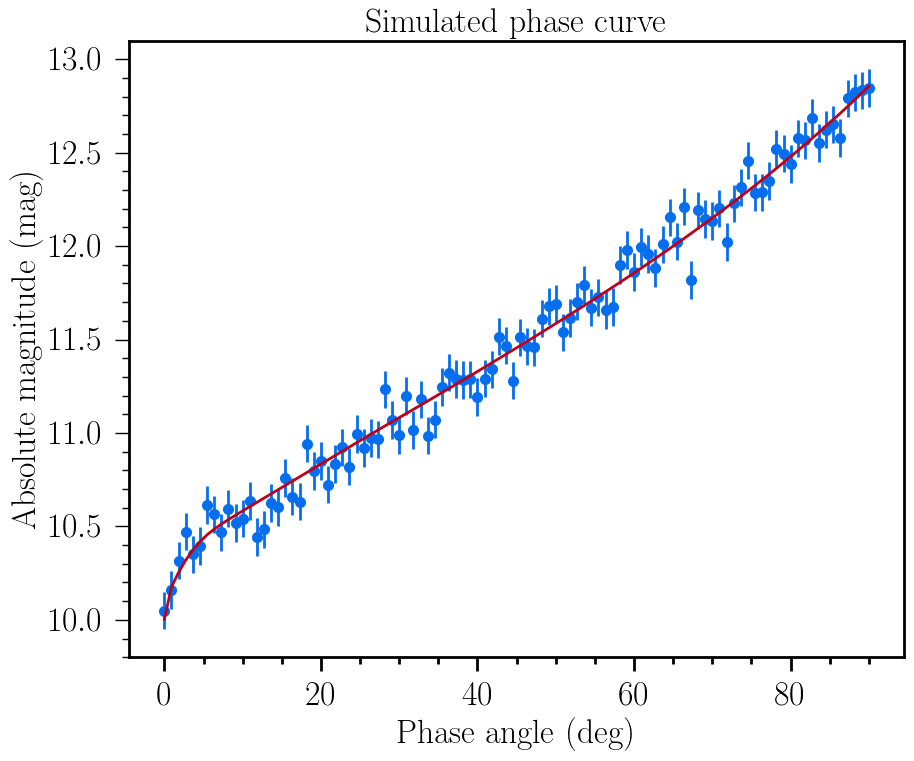

In [25]:
import qa_phot as qa
import warnings


def fitHG12(mag, magSigma, phaseAngle, tdist, rdist):
    # This uses the HG12 function from Muinonen et al (2010)
    nobsv = len(mag)

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag
    #phaseAngle = np.deg2rad(phaseAngle)

    # fit, suppressing warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        sol = qa.fit(mag, phaseAngle, magSigma)
        if sol[-1] in [1,2,3] and sol[1] is not None: #least squares solver flags       
            chi2 = np.sum(sol[2]['fvec']**2)
            H = sol[0][0]
            G = sol[0][1]
            H_err = np.sqrt(sol[1][0,0])
            G_err = np.sqrt(sol[1][1,1])
            HG_cov = sol[1][0,1]
            
            return H, G, H_err, G_err, HG_cov, chi2/(nobsv-2), nobsv
        else:
            # fit failed
            return (np.nan,) * 6 + (0,)
    
# Test of magnitude fitting

from sbpy.photometry import HG12
ph = np.linspace(0, 90, 100)
mag = HG12.evaluate(np.deg2rad(ph), 10, 0.14)
np.random.seed(42)
sigma = 0.1
mag = np.random.normal(mag, sigma)

H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = fitHG12(mag, sigma, ph, 1., 1.)

plt.scatter(ph, mag)
plt.errorbar(ph, mag, sigma, ls='none')
_ph = sorted(ph)
_mag = HG12.evaluate(np.deg2rad(ph), H, G)
plt.plot(_ph, _mag)
plt.xlabel('Phase angle (deg)')
plt.ylabel('Absolute magnitude (mag)')
plt.title('Simulated phase curve')
print(H, G, f"χ2/dof = {chi2dof}")

Example $H_r$ fit for one object

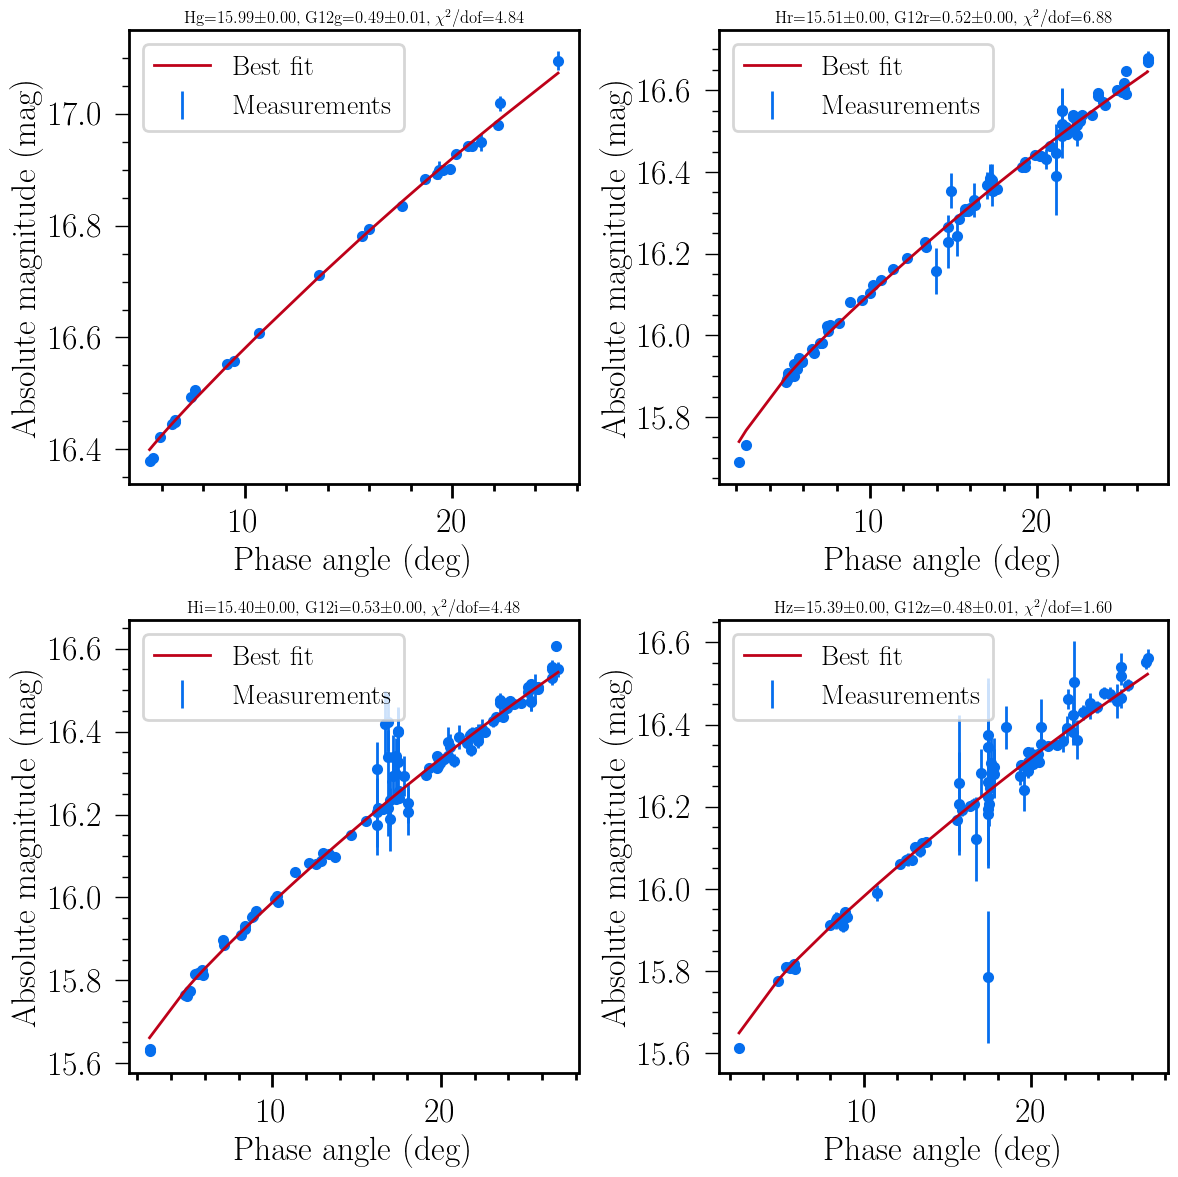

In [101]:
#band = "r".encode("ascii")
_i = splits[13]

# Extract the needed data from the DiaSource and SSSource tables
obsv = dia[["ssObjectId","filter", "mag", "magSigma", "nameTrue"]][_i]
_sss = sss[["ssObjectId","phaseAngle", "topocentricDist", "heliocentricDist"]][_i]
j = 1
fig = plt.figure()
for band in ['g', 'r', 'i', 'z']:
    plt.subplot(2,2,j)
    mask = obsv['filter'] == band.encode('ascii')
    _obsv = obsv[mask]
    sss_this = _sss[mask]
    mag = _obsv["mag"]
    #mag = obsv["mag"]
    #print(pd.DataFrame(obsv))
    #print(pd.DataFrame(_sss))
    assert np.all(_obsv["filter"] == band.encode('ascii'))
    H, G, sigmaH, sigmaG, covHG, chi2dof, nobsv = \
        fitHG12(mag, _obsv["magSigma"], sss_this["phaseAngle"], sss_this["topocentricDist"], sss_this["heliocentricDist"])

    # plot distance-corrected data
    mag1 = mag -5. * np.log10(sss_this["topocentricDist"]*sss_this["heliocentricDist"])
    p = sss_this["phaseAngle"]
    plt.scatter(p, mag1)
    plt.errorbar(p, mag1, _obsv["magSigma"], ls='none',label='Measurements')

    # best-fit overplot
    _ph = sorted(p)
    _mag = HG12.evaluate(np.deg2rad(_ph), H, G, )
    plt.plot(_ph, _mag, label='Best fit')
    plt.xlabel('Phase angle (deg)',)
    plt.ylabel('Absolute magnitude (mag)', )
    plt.legend()
    plt.title(f"H{band}={H:.2f}±{sigmaH:.2f}, G12{band}={G:.2f}±{sigmaG:.2f}, $\chi^2$/dof={chi2dof:.2f}", fontsize=12)
    j+=1
fig.set_size_inches(12,12)
plt.tight_layout()

# Flags

As part of the absolute magnitude fitting process, let's define some flags for failure cases. These will be bitwise flags, so that the combinations of multiple flags are unique. 

- Success! `FLAG = 0` (`0000000`)
- Orbit fitting failure `FLAG = 1` (`0000001`)
- $H_u$ fit failure `FLAG = 2` (`0000010`)
- $H_g$ fit failure `FLAG = 4` (`0000100`)
- $H_r$ fit failure `FLAG = 8` (`0001000`)
- $H_i$ fit failure `FLAG = 16` (`0010000`)
- $H_z$ fit failure `FLAG = 32` (`0100000`)
- $H_y$ fit failure `FLAG = 64` (`1000000`)

Example: an object whose photometry failed in u and y band will have `FLAG = 66` (in binary, `1000010`). 

Note that ` bool(flag & reference)` is `True` if `reference` is part of the `flag`. So, for example, `bool(66 & 64) = True` and `bool(66 & 4) = False`.

Compute the SSObject table columns:

In [26]:
%%time
flags_phot = {'u' : 2, 'g' : 4, 'r': 8, 'i' : 16, 'z' : 32, 'y' : 64}


def computeSSObjectRecord(args):
    k, i = args
    row = obj[k]
    obsv = dia[i]
    _sss = sss[["phaseAngle", "topocentricDist", "heliocentricDist"]][i]

    phaseAngle, topoDist, helioDist = _sss["phaseAngle"], _sss["topocentricDist"], _sss["heliocentricDist"]
    nobs = len(obsv)
    # just verify we didn't screw up something
    #print(np.unique(obsv['ssObjectId']))
    assert len(np.unique(obsv["ssObjectId"])) == 1
    assert np.all(obsv["ssObjectId"] == sss[i]["ssObjectId"])
    assert np.all(topoDist > 0.)

    # Metadata columns
    row["ssObjectId"] = obsv["ssObjectId"][0]
    row["firstObservationDate"] = obsv["midPointTai"].min()
    row["discoverySubmissionDate"] = row["firstObservationDate"] + 7. #FIXME: assume we discover everything 7 days after first obsv
    row["arc"] = obsv["midPointTai"].ptp()
    row["numObs"] = len(obsv)
    
    # let's assume no failures so far
    row['flags'] = 0
    
    # FIXME: no comets
    row["maxExtendedness"] = 0.
    row["minExtendedness"] = 0.
    row["medianExtendedness"] = 0.

    # FIXME: implement MOID
    
    # Photometry columns:
    # fit absmag/slope for each band
    for b in ("u", "g", "r", "i", "z", "y"):
        mask = obsv['filter'] == b.encode('ascii')
        
        alpha = phaseAngle[mask]

        # require at least five observations, and a decent span (10deg) of phase angles
        if np.count_nonzero(mask) >= 5 and alpha.ptp() > 5:
            H, G, sigmaH, sigmaG, covHG, chi2dof, ndata = \
                fitHG12(obsv["mag"][mask], obsv["magSigma"][mask], alpha, topoDist[mask], helioDist[mask])
            if np.isnan(H):
                flag = flags_phot[b]
            else:
                flag = 0
        else:
            H, G, sigmaH, sigmaG, covHG, chi2dof = ( np.nan, ) * 6
            ndata = 0
            flag = flags_phot[b]

        row[f"{b}H"] = H
        row[f"{b}G12"] = G
        row[f"{b}HErr"] = sigmaH
        row[f"{b}G12Err"] = sigmaG 
        row[f"{b}H_{b}G12_Cov"] = covHG
        row[f"{b}Chi2"] = chi2dof
        row[f"{b}Ndata"] = ndata
        row['flags'] += flag 
        
if False:
    # single-thread
    for k, i in enumerate(splits[:1_0]):
        print(k)
        computeSSObjectRecord((k, i))
else:
    # multi-processing pool
    from tqdm.notebook import tqdm
    from multiprocessing import Pool
    s = splits#[:100_000]
    with Pool(96) as p:
        for _ in tqdm(p.imap(computeSSObjectRecord, enumerate(s), chunksize=1000), total=len(s)):
            pass

#pd.DataFrame(obj[0:10][["rH", "rHErr", "rG12", "rG12Err", "rH_rG12_Cov", "rChi2", "rNdata"]])
pd.DataFrame(obj[0:10]).head()

  0%|          | 0/4443479 [00:00<?, ?it/s]

CPU times: user 54.8 s, sys: 45.9 s, total: 1min 40s
Wall time: 14min 41s


,ssObjectId,discoverySubmissionDate,firstObservationDate,arc,numObs,MOID,MOIDTrueAnomaly,MOIDEclipticLongitude,MOIDDeltaV,uH,uG12,uHErr,uG12Err,uH_uG12_Cov,uChi2,uNdata,gH,gG12,gHErr,gG12Err,gH_gG12_Cov,gChi2,gNdata,rH,rG12,rHErr,rG12Err,rH_rG12_Cov,rChi2,rNdata,iH,iG12,iHErr,iG12Err,iH_iG12_Cov,iChi2,iNdata,zH,zG12,zHErr,zG12Err,zH_zG12_Cov,zChi2,zNdata,yH,yG12,yHErr,yG12Err,yH_yG12_Cov,yChi2,yNdata,maxExtendedness,minExtendedness,medianExtendedness,flags
0,2150553186630,61088.33903,61081.33903,2743.640869,292,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,19.609064,0.615522,0.017851,0.098302,0.001494,1.452662,29,18.929785,0.457492,0.006722,0.035494,0.000179,1.091330,99,18.725157,0.511137,0.007771,0.044249,0.000237,0.910638,102,18.784210,0.555756,0.015886,0.092330,0.001015,1.006678,62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,66
1,3369984299447,60237.19715,60230.19715,3608.906494,73,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,21.121069,0.729043,0.033933,0.183633,0.002005,1.481137,9,20.433422,0.375160,0.017262,0.100927,0.000503,1.580575,34,20.255009,0.611849,0.020321,0.173546,0.000746,0.664985,20,20.243176,0.536995,0.037589,0.374103,-0.001520,0.660381,10,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,66
2,5992863104062,60979.25848,60972.25848,2766.826904,65,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,19.888412,0.777883,0.130168,0.666359,0.080369,0.935651,9,19.236397,1.121458,0.048226,0.306561,0.012632,1.190715,32,19.001997,0.407395,0.052871,0.362802,0.014024,0.642266,22,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,98
3,6098332225018,60238.19309,60231.19309,3624.913574,326,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16.812340,0.628721,0.010990,0.058947,0.000622,2.508380,43,16.356865,0.662213,0.004388,0.024148,0.000096,1.452524,109,16.231052,0.596206,0.004729,0.028352,0.000107,1.222447,99,16.219519,0.512872,0.009982,0.056799,0.000464,0.759882,75,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,66
4,6102997768245,60568.00433,60561.00433,3006.040771,222,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,19.314938,0.323159,0.021027,0.120261,0.001951,1.329534,27,18.703276,0.622493,0.009624,0.053717,0.000389,1.269059,84,18.456484,0.361097,0.013110,0.068518,0.000700,1.154313,72,18.481661,0.168234,0.049384,0.085888,-0.003859,1.152803,39,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,66


In [27]:
fl, counts = np.unique(obj['flags'], return_counts=True)
print(fl[np.argmax(counts)])

66


In [28]:
df_fl = pd.DataFrame({'flag' : fl, 'n_obj' : counts})

df_fl

,flag,n_obj
0,0,4
1,2,29
2,6,11
3,14,1
4,34,2
5,38,2
6,46,1
7,66,3104076
8,70,74602
9,74,2176


In [ ]:
flags = [2,4,8,16,32,64]


x_flag = []
y_flag = []
counts = []
x_single = []
single_counts = []

for i in range(len(flags)):
    x_mask = (obj['flags'] & flags[i]).astype('bool')
    for j in range(i, len(flags)):
        total = len(obj[np.logical_and(x_mask, (obj['flags'] & flags[j]).astype('bool'))])
        x_flag.append(flags[i])
        y_flag.append(flags[j])
        counts.append(total)
    x_single.append(i)
    single_counts.append(len(obj[x_mask]))

# counting 0 flag, but saving as 1 as I'll take log2(flag) for plotting        
x_single.append(1)
single_counts.append(len(obj[obj['flags'] == 0]))


In [ ]:
# just making plotting easier

counts_sc = np.array(counts)/np.min(counts)
plt.scatter(np.log2(x_flag), np.log2(y_flag), 
            c=counts, cmap='PuBuGn', vmin=2e6, vmax=10e6)
plt.colorbar(label=r'Number of objects where $x \wedge y = \mathtt{True}$', ticks=[2e6, 4e6, 6e6, 8e6,10e6])

plt.xticks([1,2,3,4,5,6], [2, 4, 8, 16, 32, 64])
plt.yticks([1,2,3,4,5,6], [2, 4, 8, 16, 32, 64])
plt.title('Flag pairs')
plt.xlabel('Flag $x$')
plt.ylabel('Flag $y$')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
single_counts = np.array(single_counts)
single_counts_sc = np.array(single_counts)/np.min(single_counts+1)

fig = plt.figure()
fig.set_size_inches(8,2)

plt.scatter(np.log2(x_single), np.ones_like(x_single), c = 1+np.log10(single_counts + 1), cmap='PuBuGn',
            )

plt.yticks([])
bar = plt.colorbar()#ticks=[0,1,3,5,7])
#bar.set_ticklabels([r'$10^0$', r'$10^2$', r'$10^4$', r'$10^6$', r'$10^8$'])
plt.xticks([0,1,2,3,4,5,6], ['None', 'u','g', 'r', 'i', 'z', 'y'])

plt.xlabel('Flag')
plt.title('Single flags')

plt.show()

So we can see that about ~2M out of ~11M objects have the full $ugrizy$ photometry fit, meaning more than 5 observations spanning more than 5 degrees of phase angle. Flags 2 (no $H_u$), 66 (no $H_u$ and $H_y$) and 98 (no $H_u$, $H_z$ and $H_y$) correspond to another ~4M objects. Flag 126 (no absolute magnitudes at all) corresponds to another ~3M objects that were only poorly observed.

Let's take a look into the $g$ and $r$ band photometry.

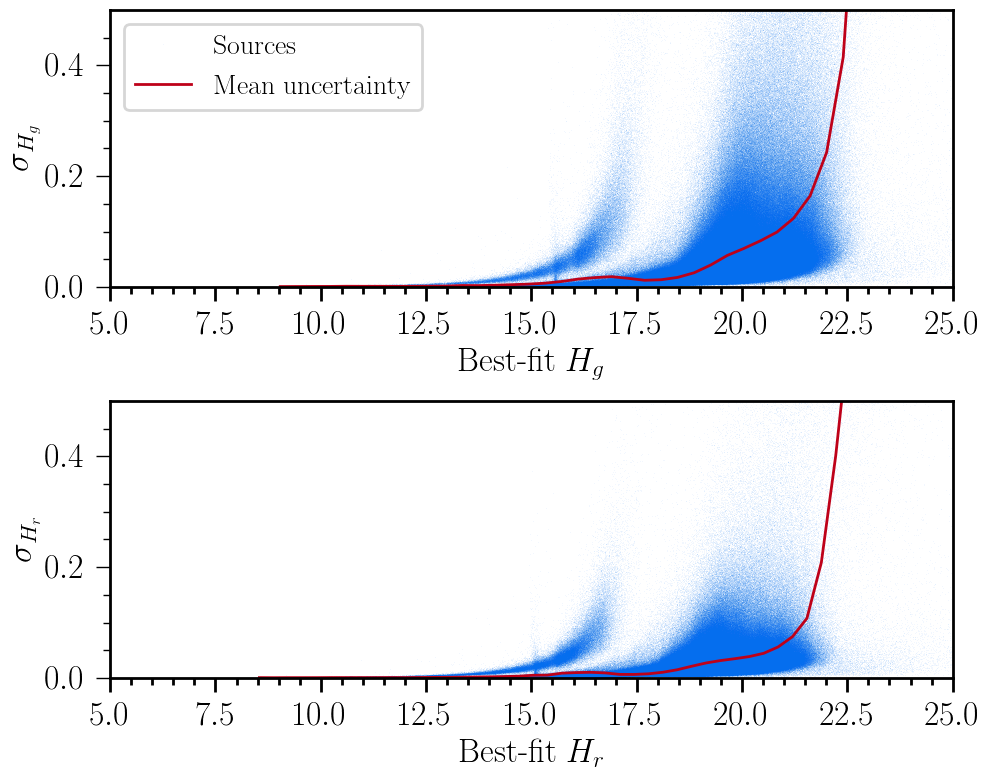

In [105]:
from scipy.stats import binned_statistic

grband = obj[np.isin(obj['flags'], [0,2,66,98,34,64])]

plt.subplot(2,1,1)
plt.plot(grband['gH'], grband['gHErr'], ',', alpha=0.05, label='Sources')
plt.ylim(0, 0.5)
plt.xlabel(r'Best-fit $H_g$')
plt.ylabel(r'$\sigma_{H_g}$')
gbandst = binned_statistic(grband['gH'], grband['gHErr'], bins=100)
plt.plot(np.diff(gbandst.bin_edges)/2 + gbandst.bin_edges[:-1], gbandst.statistic, label='Mean uncertainty')
plt.legend(loc=0)
plt.xlim(5,25)


plt.subplot(2,1,2)
plt.plot(grband['rH'], grband['rHErr'], ',', alpha=0.05)
plt.ylim(0, 0.5)
plt.xlabel(r'Best-fit $H_r$')
plt.ylabel(r'$\sigma_{H_r}$')
rbandst = binned_statistic(grband['rH'], grband['rHErr'], bins=100)
plt.plot(np.diff(rbandst.bin_edges)/2 + rbandst.bin_edges[:-1], rbandst.statistic, label='Mean uncertainty')
plt.xlim(5,25)
plt.tight_layout()
plt.show()

The plot above contains ~6M objects:

In [ ]:
len(grband)

Let's also look at the objects where everything worked correctly (`FLAGS = 0`, about 2M sources):

In [ ]:
from scipy.stats import binned_statistic

best_obj = obj[obj['flags'] == 0]

j = 1

for i in ['u', 'g', 'r', 'i', 'z', 'y']:
    plt.subplot(3,2,j)
    plt.plot(best_obj[f'{i}H'], best_obj[f'{i}HErr'], ',', alpha=0.05, label='Sources')
    plt.xlabel(f'Best-fit $H_{i}$')
    plt.ylabel(r'$\sigma_{H_' + i + '}$')
    bandst = binned_statistic(best_obj[f'{i}H'], best_obj[f'{i}HErr'], bins=50)
    plt.plot(np.diff(bandst.bin_edges)/2 + bandst.bin_edges[:-1], bandst.statistic, label='Mean error')
    plt.xlim(5,25)
    if i in ['u', 'y']:
        plt.ylim(0, 0.5)
    else:
        plt.ylim(0, 0.05)
    j+= 1
    
plt.tight_layout()
plt.show()

In [ ]:
best_obj = obj[obj['flags'] == 0]



Some timings for the above (all on epyc, with swappiness=10%, O_DIRECT flag):
* An empty imap takes about a ~minute (CPU-limited by the driver process)
* An imap w. just reading the inputs from mmapped arrays is ~6 minutes
* A full run takes ~30 min

# Simulate Linking

We'll use Joachim Moeyens' difi (https://github.com/moeyensj/difi) to simulate linking. `FLAG = 2048` will denote objects that were **not** linked.

In [29]:
from difi.metrics import NightlyLinkagesMetric

In [19]:
column_mapping = {
    # difi column name : data column name
    "object_id" : "ssObjectId",
    "obs_id" : "diaSourceId",
    "truth" : "designation",
    "night" : "night",
    "time" : "midPointTai",
    "dec" : "decl"
}
column_reverse = {column_mapping[i] : i for i in column_mapping}

from difi.metrics import NightlyLinkagesMetric

metric = NightlyLinkagesMetric(
    linkage_min_obs=2,              # min observations per tracklet 
    max_obs_separation=1.5 / 24,    # maximum time separation between subsequent observations in a tracklet [days]
    min_linkage_nights=3,           # minimum number of nights on which a tracklet must be detected
    min_obs_angular_separation=1    # minimum angular separation between observations in a tracklet [arcseconds]
)


Test run on a chunk of objects

In [25]:
#_k = 2
ii = np.concatenate(splits[0:10_000])



obsv = pd.DataFrame(sss[ii])
dias = pd.DataFrame(dia[ii])

o = mpcdf.loc[obsv["ssObjectId"].iloc[0]]
obsv["designation"] = o["mpcDesignation"].decode("ascii")
#obsv["designation"] = dias["_name"].decode("ascii")
obsv["night"] = dias["midPointTai"].astype(int)
obsv["midPointTai"] = dias["midPointTai"]

dias['night'] = dias['midPointTai'].astype(int)

dias = dias.rename(columns = column_reverse)

NameError: name 'mpcdf' is not defined

In [ ]:
findable, window_summary = metric.run(
    dias, 
    detection_window=15,            # number of nights in a rolling detection window
    min_window_nights=3,            # minimum size of a window as the rolling window is moved 
    by_object=True,                 # split observations by object instead of by window [set to True if you want ignore_after_discovery=True]
    discovery_probability=0.95,     # probability of discovery for any discovery chance
    num_jobs=30,                    # number of parallel jobs
    ignore_after_discovery=True     # ignore observations of an object after it has been discovered
)

In [ ]:
findable

In [ ]:
first_night = np.min(dia['midPointTai'])
last_night = np.max(dia['midPointTai'])
print(first_night, last_night)

In [17]:
def run_difi(chunk_begin, chunk_size):
    chunk_end = min(len(obj)-1, chunk_begin + chunk_size)
    split_array = splits[chunk_begin : chunk_end]
    detections = np.concatenate(split_array)
    
    obj_this = obj[chunk_begin : chunk_end]['ssObjectId']
        
    dias = pd.DataFrame(dia[detections])
    dias['night'] = dias['midPointTai'].astype(int)
    dias = dias.rename(columns = column_reverse)
    
    findable, window_summary = metric.run(
        dias, 
        detection_window=15,            # number of nights in a rolling detection window
        min_window_nights=3,            # minimum size of a window as the rolling window is moved 
        by_object=True,                 # split observations by object instead of by window [set to True if you want ignore_after_discovery=True]
        discovery_probability=0.95,     # probability of discovery for any discovery chance
        num_jobs=96,                    # number of parallel jobs
        ignore_after_discovery=True     # ignore observations of an object after it has been discovered
    )
    findable['object_id'] = findable['object_id'].astype('uint64')
    findable = findable.sort_values('object_id')
    
    mask = np.isin(obj_this, findable['object_id'])
    mask_obj = np.arange(chunk_begin, chunk_end)[mask]
    
    
    obj['discoverySubmissionDate'][mask_obj] = window_summary['start_night'][findable['window_id']]
    
    
    mask = np.isin(obj_this, findable['object_id'], invert=True)
    mask_obj = np.arange(chunk_begin, chunk_end)[mask]
    obj['flags'][mask_obj] += 2048

    

In [20]:
run_difi(0, 10_000)

Now, let's move on to the real deal. To avoid using an insane amount of RAM in the `difi` call, we will be chunking the data and then joining everything together.

In [30]:
%%time 
chunk_size = 100_000
from tqdm.notebook import tqdm


for i in tqdm(range(len(obj)//chunk_size + 1)):
    
    run_difi(i * chunk_size, chunk_size)



  0%|          | 0/45 [00:00<?, ?it/s]

CPU times: user 4h 13min 55s, sys: 2h 38s, total: 6h 14min 33s
Wall time: 7h 3min 26s


In [31]:
fl, counts = np.unique(obj['flags'], return_counts=True)
print(fl[np.argmax(counts)])
df_fl = pd.DataFrame({'flag' : fl, 'n_obj' : counts})

df_fl

66


,flag,n_obj
0,0,4
1,2,23
2,6,4
3,34,2
4,66,3078718
5,70,69513
6,74,2088
7,78,7929
8,82,3897
9,86,7925


In [32]:
np.sum(df_fl[df_fl['flag'] > 2048]['n_obj'])

221293

In [33]:
obj

array([(       2150553186630, 61069.     , 61081.33903, 2743.6409, 292, 0., 0., 0., 0., nan, nan, nan, nan, nan, nan, 0, 19.609064, 0.61552167, 0.01785084, 0.09830236,  1.4942531e-03, 1.4526622 , 29, 18.929785, 0.45749247, 0.0067224 , 0.03549409,  1.7905454e-04,  1.0913296, 99, 18.725157, 0.51113707, 0.00777052, 0.04424924,  2.3688274e-04,  0.91063833, 102, 18.78421 , 0.55575633, 0.0158864 , 0.09232987,  1.0152422e-03, 1.0066775 , 62, nan, nan, nan, nan, nan, nan, 0, 0., 0., 0., 66),
       (       3369984299447, 60222.     , 60230.19715, 3608.9065,  73, 0., 0., 0., 0., nan, nan, nan, nan, nan, nan, 0, 21.121069, 0.7290429 , 0.03393349, 0.18363303,  2.0049468e-03, 1.481137  ,  9, 20.433422, 0.3751602 , 0.01726171, 0.10092741,  5.0277793e-04,  1.5805749, 34, 20.255009, 0.61184937, 0.02032071, 0.1735462 ,  7.4565393e-04,  0.6649848 ,  20, 20.243176, 0.5369947 , 0.03758917, 0.37410253, -1.5199368e-03, 0.6603806 , 10, nan, nan, nan, nan, nan, nan, 0, 0., 0., 0., 66),
       (       5992863

In [34]:
closeArray(obj_mm, obj_fp)

In [ ]:
import awkward as ak
arr = ak.Array(splits)

In [ ]:
import pickle
with open(f"{output_dir}/indicesAwk.pkl", "wb") as ff:
    pickle.dump(i, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjectId, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ssObjects, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(arr, ff, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(nobj, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
! ls -lh "{output_dir}"

In [ ]:
import matplotlib.pyplot as plt
arr = np.fromiter(map(len, splits), dtype=np.uint32)
plt.hist(arr, bins=100, range=(0,100))

# Utilities

Mass-convert HDF inputs to CSV files (e.g., for easy inspection and grepping).

In [ ]:
def _createToCSV_mapper(fn):
    # load
    try:
        det = pd.read_hdf(fn).reset_index()
    except:
        print("ERROR: ", output)
        return (output, 0)

    # write to CSV
    det.to_csv(fn + ".csv", index=False)
    
    return fn, len(det)

def convertToCSV(inputs):
    import os
    from tqdm.notebook import tqdm

    from multiprocessing import Pool
    with Pool(48) as p:
        outputs = dict(tqdm(
            p.imap(
                _createToCSV_mapper, inputs["filename"].values
            ), total=len(inputs)
        ))

    return outputs

outputs = convertToCSV(inputs)
#outputs = dict([_createToCSV_mapper(inputs["filename"].loc[0])])

print(f"Converted {len(outputs)} files, {sum(outputs.values())} rows.")

## Postgres bulk importer

The code below creates control files for pg_bulkload, so we can directly load the binary tables into the postgres database.

In [ ]:
typemap = dict(
    i = "INTEGER",
    u = "INTEGER",
    f = "REAL",
    S = "CHAR"
)

def bulkload_type_for_dtype(dtype, offset=None):
    #
    # Convert dtype to type strings for pg_bulkload .ctl files
    #

    # 'code' will be something like <u8 or |S12
    assert len(dtype.descr) == 1
    _, code = dtype.descr[0]
    dbtype = typemap[code[1]]
    size = code[2:]
    if offset is not None:
        offset = f"{offset+1}+"
    else:
        offset = ''

    # Hack to recognize NaN as NULLs
    if dbtype == 'REAL':
        if size == "4":
            nullif = " NULLIF 0000c07f"
        else:
            nullif = " NULLIF 000000000000f87f"
    else:
        nullif = ""

    return f"{dbtype}({offset}{size}){nullif}"


def pgsql_type_for_dtype(dtype, offset=None):
    #
    # Convert dtype to type strings for Postgres' CREATE TABLE
    # FIXME: Postgres doesn't have unsigned ints. What should
    #        we do?
    #
    
    # 'code' will be something like <u8 or |S12
    assert len(dtype.descr) == 1
    _, code = dtype.descr[0]
    size = int(code[2:])
    
    if code[1] in ['i', 'u']:
        dbtype = "int"+str(size)
    elif code[1] == 'f':
        dbtype = "real" if size == 4 else "double precision"
    elif code[1] == "S":
        dbtype = f"CHAR({size})"
    else:
        assert False, f"Unknown datatype {dtype}"

    return dbtype

def gen_create_table_sql(tableName, dtype):
    sql = []
    sql.append(f"drop table if exists {tableName};")
    sql.append(f"create table {tableName} (")
    # pg_bulkload config file text
    flds = []
    for name, field in dtype.fields.items():
        dbtype = pgsql_type_for_dtype(field[0])
        flds.append(f"    {name} {dbtype}")
    sql.append(",\n".join(flds))
    sql.append(")")
    return '\n'.join(sql)

def gen_pg_bulkload_ctl(inputFn, tableName, dtype, limit=10):
    # convert inputFn to absolute
    ctl=[]
    ctl.append(f"INPUT = {inputFn}")
    ctl.append("TYPE = BINARY")
    if limit is not None:
        ctl.append(f"LIMIT = {limit}")
    ctl.append(f"OUTPUT = {tableName}")
    ctl.append("WRITER = DIRECT")

    # pg_bulkload config file text
    for name, field in dtype.fields.items():
        offset = field[1]
        dbtype = bulkload_type_for_dtype(field[0], offset)
        ctl.append(f"COL = {dbtype}")

    return '\n'.join(ctl)

def bulkload(dbname, tableName, inputFn, arr, limit=10):
    dtype = arr.dtype
    
    sqlFn = f"{output_dir}/{tableName}.sql"
    ctlFn = f"{output_dir}/{tableName}.ctl"

    with open(sqlFn, "w") as fp:
        print(gen_create_table_sql(tableName, dtype), file=fp)

    with open(ctlFn, "w") as fp:
        print(gen_pg_bulkload_ctl(inputFn, tableName, dtype, limit=limit), file=fp)

    print(f"sudo -u postgres psql -f {sqlFn} {dbname}")
    print(f"sudo -u postgres time /usr/pgsql-13/bin/pg_bulkload -d {dbname} {ctlFn}")
    print(f"sudo -u postgres psql {dbname} -c 'select * from {tableName} limit 5'")

bulkload("lsst_solsys", "mpc2", "mpcorb.npy", mpc, limit=None)
bulkload("lsst_solsys", "ssObjects", "ssObject.npy", obj, limit=None)
bulkload("lsst_solsys", "diaSources", "diaSource.npy", dia, limit=None)
bulkload("lsst_solsys", "ssSources", "ssSource.npy", sss, limit=None)

```
# Code to build indices; run this manually after import

# performance: https://www.cybertec-postgresql.com/en/postgresql-parallel-create-index-for-better-performance/

SHOW maintenance_work_mem;
SHOW max_parallel_workers;
SHOW max_parallel_maintenance_workers;

SET maintenance_work_mem TO '40 GB';
SET max_parallel_maintenance_workers TO 10;

ALTER TABLE mpcorb SET (parallel_workers = 32);
alter table mpcorb add primary key (mpcdesignation);
create unique index ON mpcorb(ssObjectId);
create unique index ON mpcorb(mpcDesignation);
create index ON mpcorb(q);
create index ON mpcorb(e);
create index ON mpcorb(incl);
create index ON mpcorb(mpcH);

ALTER TABLE ssObjects SET (parallel_workers = 32);
create unique index ON ssObjects(ssObjectId);
create index ON ssObjects(numObs);
create index ON ssObjects(arc);

ALTER TABLE diaSources SET (parallel_workers = 32);
create unique index ON diaSources(diaSourceId);
create index ON diaSources(ssObjectId);
create index ON diaSources(midPointTai);
create index ON diaSources(ccdVisitId);
create index ON diaSources(ra);
create index ON diaSources(decl);
create index ON diaSources(filter);

ALTER TABLE ssSources SET (parallel_workers = 32);
create unique index ON ssSources(diaSourceId);
create index ON ssSources(ssObjectId);
create index ON ssSources(eclipticLambda);
create index ON ssSources(eclipticBeta);
```

```
CREATE USER sssc WITH PASSWORD --quoted-password-here--;
GRANT CONNECT ON DATABASE lsst_solsys TO sssc;
GRANT USAGE ON SCHEMA public TO sssc;
GRANT SELECT ON ALL TABLES IN SCHEMA public TO sssc;
ALTER DEFAULT PRIVILEGES IN SCHEMA public GRANT SELECT ON TABLES TO sssc;
```

Use this to disconnect connected users when needed (e.g., to import new versions of tables).

```sql
SELECT pid, username
FROM pg_stat_activity
WHERE pg_stat_activity.datname = 'lsst_solsys' -- ← change this to your DB
  AND pid <> pg_backend_pid();
```

## Parallel Sort

Implemented from https://stackoverflow.com/questions/27551363/parallel-in-place-sort-for-numpy-arrays

Fast but unfortunately doesn't work on structured arrays :(

In [ ]:
from parallelSort import numpyParallelSort

In [ ]:
import numpy as np 
a = np.random.random(1_000_000_000)
b = a.copy()

In [ ]:
%%time
b.sort()

In [ ]:
%%time
numpyParallelSort(a)
print(a[:10])

In [ ]:
np.all(a == b)

## Convert .npy files to partitioned parquet

In [ ]:
# Serialize the results as (chunked) parquet files. We pass the array by name
# to avoid multiprocessing attempting to serialize it. We could pass individual chunks
# but ser/deser would take a lot of time. It's a hack, but works quite well.

def _write_partition(args):
    part, begin, arr, fnprefix, chunksize = args
    arr = globals()[arr]

    end = begin + chunksize
    df = pd.DataFrame(arr[begin:end])

    fn = f"{fnprefix}-part-{part:05d}.parquet"
    df.to_parquet(fn)

def write_partitioned_parquet(arrname, fnprefix, chunksize=10_000_000, pool=None):
    global _arr, _fnprefix, _chunksize
    arr = globals()[arrname]
    splits = [ (part, begin, arrname, fnprefix, chunksize) for part, begin in enumerate(range(0, len(arr), chunksize)) ]

    if False:
         # single-thread
        for args in splits:
            _write_partition(args)
    else:
        # multi-processing pool
        from tqdm.notebook import tqdm
        from multiprocessing import Pool
        if pool is None:
             pool = Pool(48)
        for _ in tqdm(pool.imap_unordered(_write_partition, splits), total=len(splits)):
            pass

In [ ]:
#%%time
from multiprocessing import Pool
with Pool(48) as pool:
    write_partitioned_parquet("mpc", f"{output_dir}/pq/mpcorb", pool=pool)
    write_partitioned_parquet("obj", f"{output_dir}/pq/ssObject", pool=pool)
    write_partitioned_parquet("dia", f"{output_dir}/pq/diaSource", pool=pool)
    write_partitioned_parquet("sss", f"{output_dir}/pq/ssSource", pool=pool)

In [ ]:
! pwd

Spot-check by reading a few files...

In [ ]:
def test_pq_output(arr, fnprefix, part, chunksize=10_000_000):
    df = pd.read_parquet(f"{fnprefix}-part-{part:05d}.parquet")
    df1 = pd.DataFrame(arr[part*chunksize:][:chunksize])

    return df, df1.equals(df)

df, ok = test_pq_output(obj, f"{output_dir}/pq/ssObject", 1); assert ok
df, ok = test_pq_output(mpc, f"{output_dir}/pq/mpcorb", 1); assert ok
df, ok = test_pq_output(dia, f"{output_dir}/pq/diaSource", 44); assert ok
df, ok = test_pq_output(sss, f"{output_dir}/pq/ssSource", 12); assert ok

In [ ]:
df

## Scraps...

Below are scraps from debugging...

In [ ]:
pd.DataFrame(mpc[:5])

In [ ]:
len(dia)

In [ ]:
int(''.join(reversed(['fe', '06', '71', '2b','82', 'd7', '1a', 'db'])), base=16)

In [ ]:
mpc.dtype.descr

In [ ]:
mpc[0]

In [ ]:
hex(10752)

In [ ]:
int(''.join(reversed(['00', '00', '00', '00',])), base=16)

In [ ]:
mpc[0]["mpcNumber"] = int(''.join(reversed(['00', '00', '00', '00',])), base=16)